In [258]:
import pandas as pd
import numpy as np
from scipy.stats import stats
import os
import matplotlib.pyplot as plt
from random import choices
import xgboost as xgb
import xgboost as XGBClassifier

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score

import sys
sys.path.append('../src/')
import matrix_convert as mc


In [113]:
def Filter_low_Expr(arr):
    total_len = len(arr)
    count = 0
    for i in arr:
        if i > 0:
            count = count + 1
    if count > 0.5*total_len: #If 
        return(True)
    else:
        return(False)
    
def formating_relative_expression(input_data,selected_genes_id, sele_house_keeping_id, KG_reg,dic_gene_map):
    array_list = []
    new_id_list = []
    print("House keeping genes:")
    for gene1 in selected_genes_id:

        for gene2 in sele_house_keeping_id:
            #print(gene2 + ":" + gene1)
            new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
            new_arr_bi = []
            for i in new_arr:
                if i > 0:
                    new_arr_bi.append(1)
                else:
                    new_arr_bi.append(0)
            array_list.append(new_arr_bi)
            new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    print("Regulators:")
    for gene1 in selected_genes_id:
        cur_sele = KG_reg.loc[KG_reg['Target_gene'] == gene1]
        cur_regulators = list(cur_sele.loc[cur_sele['Coef'] < 0]['Regulator'])
        if gene1+"_intercept_" in cur_regulators:
            cur_regulators.remove(gene1+"_intercept_")
        #cur_regulators.remove(gene1+"_RSS")
        cur_regulators_ids = []
        for gene2 in cur_regulators:
            gene2 = dic_gene_map[gene2]
            if gene2 in dic_gene_map and gene2 in input_data.index:
                #print(gene2 + ":" + gene1)
                
                #cur_regulators_ids.append(dic_gene_map[i])
                new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
                new_arr_bi = []
                for i in new_arr:
                    if i > 0:
                        new_arr_bi.append(1)
                    else:
                        new_arr_bi.append(0)
                array_list.append(new_arr_bi)
                new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    new_feature_df = pd.DataFrame(array_list)
    new_feature_df.columns = input_data.columns
    new_feature_df.index = new_id_list
    new_feature_df_t = new_feature_df.transpose()
    return(new_feature_df_t)


def train_test_split_gq(df_sele, binary_cutoff, test_size):
    from sklearn.model_selection import train_test_split
    df_neg = df_sele.loc[df_sele['ic50'] > binary_cutoff]
    df_train_1, df_test_1 = train_test_split(df_neg, test_size = test_size)
    df_pos = df_sele.loc[df_sele['ic50'] <= binary_cutoff]
    df_train_2, df_test_2 = train_test_split(df_pos, test_size = test_size)
    
    df_train = pd.concat([df_train_1,df_train_2])
    df_test = pd.concat([df_test_1, df_test_2])
    
    return(df_train, df_test)

def model_run_with_Independent_testSet(train_data,test_data, train_labels, test_labels, independent_labels, independent_features): #modified at 11:46 AM Feb 15
    #xgb_model = xgb.XGBClassifier(n_jobs=4)
    #clf = GridSearchCV(xgb_model, {'max_depth': [5],
    #                               'n_estimators': [100], 
    #                               'learning_rate': [ 0.1],
    #                               #'gamma':[1],
    #                               #'eta':[0.2,0.3,0.4],
    #                              # 'min_child_weight':[1,2],
    #                              # 'lambda':[1,2],
    #                              # 'subsample':[0.8]
    #                              }, verbose=1,cv=5, n_jobs=4) #5-fold cross validation

    #clf.fit(train_data, train_labels.values)
    #print(clf.best_score_) #Train data
    #para = (clf.best_params_)
    #print(clf.best_params_)

    xgb_model = xgb.XGBClassifier(n_jobs=4, 
                                  learning_rate = 0.05, 
                                  max_depth= 8, 
                                  n_estimators= 100)
    
    xgb_model.fit(train_data,train_labels.values)
    #predictions = xgb_model.predict(test_data)
    
    predictions_train = xgb_model.predict(train_data)


    predictions = xgb_model.predict(test_data)
    
    predictions_independent = xgb_model.predict(independent_features)
    

    #print(pd.DataFrame({"Meausred": list(test_labels), "Predict": predictions}))
    # Evaluate the accuracy of the XGBoost model in the training set (beatAML wave 1/2)
    accuracy_train = accuracy_score(train_labels, predictions_train)
    cm_train = confusion_matrix(  list(train_labels), predictions_train)
    tn_train = cm_train[0,0] #labled as negative and predicted as negative
    fp_train = cm_train[0,1] #labeld as negative and predicted as positive
    fn_train = cm_train[1,0] #labeld as positive, and predicted as negative
    tp_train = cm_train[1,1] #labeld as positive, and predicted as positive

    sensitivity_train = cm_train[1,1]/(cm_train[1,0] + cm_train[1,1]) # TP/(FN + TP)
    specificity_train = tn_train/(tn_train+fp_train)

    precision_train = cm_train[1,1]/(cm_train[0,1] + cm_train[1,1])
    recall_train = recall_score(train_labels, predictions_train)
    blanced_acc_train = (sensitivity_train + specificity_train) /2
    f1_train = f1_score(list(train_labels), predictions_train)


    # Evaluate the accuracy of the XGBoost model in the validation set (beatAML wave 1/2)
    accuracy = accuracy_score(test_labels, predictions)
    cm = confusion_matrix(  list(test_labels), predictions)
    tn = cm[0,0] #labled as negative and predicted as negative 
    fp = cm[0,1] #labeld as negative and predicted as positive
    fn = cm[1,0] #labeld as positive, and predicted as negative
    tp = cm[1,1] #labeld as positive, and predicted as positive
    
    sensitivity = cm[1,1]/(cm[1,0] + cm[1,1]) # TP/(FN + TP)
    specificity = tn/(tn+fp)
    
    precision = cm[1,1]/(cm[0,1] + cm[1,1])
    recall = recall_score(test_labels, predictions)
    blanced_acc = (sensitivity + specificity) /2 
    f1 = f1_score(list(test_labels), predictions)
    
    # Evaluate the accuracy of the XGBoost model in the testing set (beatAML wave 3/4)
    accuracy_independent = accuracy_score(independent_labels, predictions_independent)
    f1_independent = f1_score(independent_labels, predictions_independent)
    cm_independent = confusion_matrix(  list(independent_labels), predictions_independent)
    tn_independent = cm_independent[0,0] #labled as negative and predicted as negative 
    fp_independent = cm_independent[0,1] #labeld as negative and predicted as positive
    fn_independent = cm_independent[1,0] #labeld as positive, and predicted as negative
    tp_independent = cm_independent[1,1] #labeld as positive, and predicted as positive
    
    sensitivity_independent = cm_independent[1,1]/(cm_independent[1,0] + cm_independent[1,1]) # TP/(FN + TP)
    specificity_independent = tn_independent/(tn_independent+fp_independent)
    
    precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
    recall_independent = recall_score(independent_labels, predictions_independent)
    blanced_acc_independent = (sensitivity_independent + specificity_independent) /2 
    recall_independent = recall_score(independent_labels, predictions_independent)
    # F1 = 2 x [(Precision x Recall) / (Precision + Recall)]

    #print("F1_score: " + str(f1))
    #print("# F1: 2 x [(Precision x Recall) / (Precision + Recall)]")

    result_feature = pd.DataFrame({"Feature":list(test_data.columns), "IMP":xgb_model.feature_importances_})
    result_feature= result_feature.loc[result_feature['IMP']>0].sort_values(by = ['IMP'], ascending = False)

    #features = ((list(result_feature.loc[result_feature['IMP']>0.05].sort_values(by = ["IMP"], ascending = False)['Feature'])))

    result_summary = {}
    #result_summary['random_state'] = random_

    result_summary['train_accuracy'] = accuracy_train
    result_summary['train_precision'] = precision_train
    result_summary['train_sensitivity'] = sensitivity_train
    result_summary['train_F1_score'] = f1_train
    result_summary['train_specificity'] = specificity_train
    result_summary['train_balanced_acc'] = blanced_acc_train
    result_summary['train_recall'] = recall_train
    

    #result_summary['best_params'] = clf.best_params_
    result_summary['Accuracy'] = accuracy #1
    result_summary['Precision'] = precision #2
    result_summary['sensitivity'] = sensitivity #3
    result_summary['F1_score'] = f1 #4
    result_summary['specificity'] = specificity #5
    result_summary['balanced_acc'] = blanced_acc #6
    result_summary['recall'] = recall #7
    
    
    result_summary['precision_independent'] = precision_independent #1
    result_summary['sensitivity_independent'] = sensitivity_independent #2
    result_summary['specificity_independent'] = specificity_independent #3
    result_summary['blanced_acc_independent'] = blanced_acc_independent #4
    result_summary['ACC_independent'] = accuracy_independent #5
    result_summary['F1_score_independent'] = f1_independent #6
    result_summary['recall_independent'] = recall_independent #7
    
    result_summary['features'] = result_feature
    return(result_summary)


#### The BeatAML wave 1/2 dataset is from the Tyler 2018 paper, and the BeatAML wave 3/4 dataset is from the Cancer Cell 2022 paper. The gene expression values are in general similar, but not exactly the same according to the data processing steps.




In [259]:
#data_all_w12 = pd.read_csv("../Data/beatAML_wave12_feature_ic50_highExpr_Mar19_2024_w12.csv", index_col= "Unnamed: 0")

# Load all data for beat AML wave 1 to 4 from the 2022 paper
data_all_w14 = pd.read_csv("../Data/beatAML_wave14_feature_ic50_highExpr_Mar19_2024_w1_4.csv", index_col= "Unnamed: 0")
print("wave 1 to 4 data:")
print(data_all_w14.shape)
print(data_all_w14.columns[0:23]) # Feature set 1 is from column 0 to 23
print(data_all_w14.columns[23:41]) # Feature set 2 is from column 23 to 41
#print(data_all_w14.columns[41:19894]) # Feature set 3 is from column 41 to 19894
#print(data_all_w14.columns[19894:20215]) # Drug response data is from column 19894 to 20215

# Load all data from the beat AML wave 1 to 2 data from the 2018 paper
data_all_w12 = pd.read_csv("../Data/beatAML_wave12_feature_ic50_highExpr_Apr30_2024_w12.csv", index_col= "Unnamed: 0")
print("wave 1 to 2 data:")
print(data_all_w12.shape)
print(data_all_w12.columns[0:22])
print(data_all_w12.columns[22:40])
#print(data_all_w12.columns[40:17731])
#print(data_all_w12.columns[17731:17853])

wave 1 to 4 data:
(969, 20215)
Index(['FLT3', 'SRSF2', 'CEBPA', 'SF3B1', 'NPM1', 'KRAS', 'RUNX1', 'DNMT3A',
       'ASXL1', 'IDH2', 'PTPN11', 'JAK2', 'PDS5B', 'STAG2', 'IDH1', 'BCOR',
       'TET2', 'GATA2', 'U2AF1', 'EZH2', 'WT1', 'NRAS', 'TP53'],
      dtype='object')
Index(['DNMT3A:p.R882', 'ASXL1:p.G645-646', 'FLT3:p.835-839', 'IDH1:p.R132',
       'IDH2:p.R140', 'IDH2:p.R172', 'JAK2:p.V617', 'KIT:p.D816',
       'KRAS:p.G12/13', 'NPM1:p.W288-90', 'NRAS:p.G12/13', 'NRAS:p.Q61',
       'SF3B1:p.K700E', 'SF3B1:p.K666', 'SRSF2:p.94-95', 'U2AF1:p.S34',
       'U2AF1:p.156-157', 'ZNF687:p.R939Pfs*36:151262327'],
      dtype='object')
wave 1 to 2 data:
(783, 17853)
Index(['EZH2', 'DNMT3A', 'BCOR', 'SF3B1', 'TET2', 'KRAS', 'U2AF1', 'CEBPA',
       'NPM1', 'GATA2', 'PTPN11', 'IDH2', 'NRAS', 'ASXL1', 'RUNX1', 'JAK2',
       'FLT3', 'WT1', 'STAG2', 'TP53', 'IDH1', 'SRSF2'],
      dtype='object')
Index(['DNMT3A:p.R882', 'ASXL1:p.G645-646', 'FLT3:p.835-839', 'IDH1:p.R132',
       'IDH2:p.R140'

#### Theare are 672 samples from the Beat AML wave 1/2 and 297 samples from wave 3/4


In [260]:
w12_shared_samples = list(set(data_all_w12.index).intersection(set(data_all_w14.index)))
print(len(w12_shared_samples))

w34_samples = list(set(data_all_w14.index) - set(w12_shared_samples))
print(len(w34_samples))

672
297


In [5]:
#for i in range(0,2,1):
#    feature = data_all_w12.columns[i]

#    x = pd.concat([data_all_w12.loc[w12_shared_samples,[feature]], 
#            data_all_w14.loc[w12_shared_samples,[feature]]], axis=1)
#    x.columns = [feature+'_w12', feature+'_w14']
#    x = x.dropna()
#
#    plt.scatter(x[feature+'_w12'], x[feature+'_w14'])
#    plt.xlabel('wave 1/2')
#    plt.ylabel('wave 1/4')
#    plt.title(feature)
 #   plt.show()

In [6]:

# Load testing data from BeatAML wave 3 and 4
#BeatAML_wave_3_expr = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/rnaseq/beataml_waves1to4_allnorm.txt", sep = "\t") 
#BeatAML_wave_3_drugResponse = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/inhibitor/beataml_probit_curve_fits_v4_distr_nonproprietary.txt", sep = "\t")

# read xlsx file
#BeatAML_all_clinic = pd.read_excel("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/clinical/beataml_wv1to4_clinical_summary_01_22_2021.xlsx")


In [261]:
BeatAML_w12_samples = set(data_all_w12.index).intersection(set(data_all_w14.index))
print(len(BeatAML_w12_samples))


672


In [262]:
BeatAML_w34_samples = set(data_all_w14.index) - BeatAML_w12_samples
BeatAML_w12_samples = set(data_all_w14.index).intersection(BeatAML_w12_samples)



In [263]:
data_all_w14.loc[:,set2].sum(axis = 0).sort_values(ascending = False)   

NPM1:p.W288-90                   22.123437
SRSF2:p.94-95                    14.461332
DNMT3A:p.R882                    13.406682
IDH2:p.R140                      13.126730
ASXL1:p.G645-646                  7.396917
IDH1:p.R132                       6.813941
NRAS:p.Q61                        6.608028
NRAS:p.G12/13                     6.526184
FLT3:p.835-839                    5.446509
U2AF1:p.S34                       5.406890
KRAS:p.G12/13                     4.529595
JAK2:p.V617                       4.107686
SF3B1:p.K666                      3.195401
IDH2:p.R172                       2.320944
KIT:p.D816                        1.846102
SF3B1:p.K700E                     1.558358
U2AF1:p.156-157                   0.900000
ZNF687:p.R939Pfs*36:151262327     0.707502
dtype: float64

In [264]:
BeatAML_w12_data = data_all_w12.loc[list(BeatAML_w12_samples),:]  # This is important to make sure which dataset is used for beatAML wave 1/2
BeatAML_w34_data = data_all_w14.loc[list(BeatAML_w34_samples),:]

print(len(BeatAML_w12_samples))
print(len(BeatAML_w34_samples))

672
297


In [265]:
BeatAML_w34_data.loc[:,set2].sum(axis = 0).sort_values(ascending = False)

NPM1:p.W288-90                   18.678855
SRSF2:p.94-95                    12.754193
IDH2:p.R140                      12.226597
DNMT3A:p.R882                    10.569628
ASXL1:p.G645-646                  6.832514
NRAS:p.G12/13                     6.526184
NRAS:p.Q61                        6.199223
IDH1:p.R132                       5.862727
U2AF1:p.S34                       4.906890
FLT3:p.835-839                    4.867220
KRAS:p.G12/13                     4.529595
JAK2:p.V617                       3.153979
SF3B1:p.K666                      2.819874
IDH2:p.R172                       2.320944
SF3B1:p.K700E                     1.558358
U2AF1:p.156-157                   0.900000
ZNF687:p.R939Pfs*36:151262327     0.707502
KIT:p.D816                        0.598090
dtype: float64

In [266]:
BeatAML_w12_data.loc[:,set2].sum(axis = 0).sort_values(ascending = False)

NPM1:p.W288-90                   36.037696
DNMT3A:p.R882                    32.848633
SRSF2:p.94-95                    29.915678
IDH2:p.R140                      22.519558
IDH1:p.R132                      20.942126
NRAS:p.G12/13                    18.801233
FLT3:p.835-839                   11.355035
JAK2:p.V617                      10.386895
NRAS:p.Q61                        8.130113
SF3B1:p.K666                      8.033271
ASXL1:p.G645-646                  6.580722
U2AF1:p.S34                       5.539027
IDH2:p.R172                       4.976342
KRAS:p.G12/13                     4.799768
U2AF1:p.156-157                   4.675217
SF3B1:p.K700E                     3.693759
KIT:p.D816                        3.467462
ZNF687:p.R939Pfs*36:151262327     1.752414
dtype: float64

In [267]:
BeatAML_w12_data_set1 = BeatAML_w12_data.columns[0:22]
BeatAML_w12_data_set2 = BeatAML_w12_data.columns[22:40]
BeatAML_w12_data_set3 = BeatAML_w12_data.columns[40:40+17691]


BeatAML_w34_data_set1 = BeatAML_w34_data.columns[0:23]
BeatAML_w34_data_set2 = BeatAML_w34_data.columns[23:41]
BeatAML_w34_data_set3 = BeatAML_w34_data.columns[41:41+19853]

featureset_1 = list(set(BeatAML_w12_data_set1).intersection(set(BeatAML_w34_data_set1)))
featureset_2 = list(set(BeatAML_w12_data_set2).intersection(set(BeatAML_w34_data_set2)))
featureset_3 = list(set(BeatAML_w12_data_set3).intersection(set(BeatAML_w34_data_set3)))

print([len(featureset_1), len(featureset_2), len(featureset_3)])

print(featureset_1)
print(featureset_2)
#print(featureset_3)

[22, 18, 17685]
['IDH1', 'TP53', 'STAG2', 'GATA2', 'FLT3', 'ASXL1', 'NRAS', 'DNMT3A', 'CEBPA', 'IDH2', 'BCOR', 'EZH2', 'SF3B1', 'PTPN11', 'WT1', 'KRAS', 'TET2', 'JAK2', 'RUNX1', 'U2AF1', 'SRSF2', 'NPM1']
['SF3B1:p.K700E', 'ASXL1:p.G645-646', 'IDH2:p.R140', 'IDH1:p.R132', 'KIT:p.D816', 'FLT3:p.835-839', 'SF3B1:p.K666', 'SRSF2:p.94-95', 'JAK2:p.V617', 'KRAS:p.G12/13', 'U2AF1:p.S34', 'NRAS:p.G12/13', 'ZNF687:p.R939Pfs*36:151262327', 'NRAS:p.Q61', 'NPM1:p.W288-90', 'IDH2:p.R172', 'U2AF1:p.156-157', 'DNMT3A:p.R882']


In [268]:
BeatAML_w12_data_set3_df = BeatAML_w12_data[featureset_3]
BeatAML_w12_data_set3_df_t = BeatAML_w12_data_set3_df.transpose()
print(BeatAML_w12_data_set3_df_t.shape)
BeatAML_w12_data_set3_df_t.head(4)

(17685, 672)


,16-00970,14-00045,13-00165,17-00021,16-00132,16-01254,14-00774,14-00015,13-00622,10-00172,...,14-00715,13-00393,15-00571,16-00356,17-00077,14-00004,16-00541,13-00123,14-00289,13-00546
ENSG00000117650,NaN,-0.298535,0.473776,NaN,0.994257,2.709721,3.534034,3.860261,NaN,NaN,...,NaN,5.194990,NaN,5.323348,NaN,NaN,NaN,1.568020,5.447047,1.179434
ENSG00000131759,NaN,5.126206,5.547915,NaN,6.907296,7.521682,5.347501,7.215490,NaN,NaN,...,NaN,6.942664,NaN,8.746077,NaN,NaN,NaN,7.390279,5.917206,5.503045
ENSG00000265517,NaN,-0.249359,1.297656,NaN,-0.472285,-0.382494,4.566894,-0.749707,NaN,NaN,...,NaN,2.392192,NaN,-2.863880,NaN,NaN,NaN,-0.738841,1.193949,2.200932
ENSG00000223773,NaN,4.707798,4.043885,NaN,4.369054,3.712522,5.714815,2.880571,NaN,NaN,...,NaN,5.118108,NaN,3.749034,NaN,NaN,NaN,2.635663,2.705323,5.141147


In [269]:
BeatAML_w34_data_set3_df = BeatAML_w34_data[featureset_3]
BeatAML_w34_data_set3_df_t = BeatAML_w34_data_set3_df.transpose()
print(BeatAML_w34_data_set3_df_t.shape)
BeatAML_w34_data_set3_df_t.head(4)


(17685, 297)


,19-00165,18-00073,13-00318,17-00457,18-00077,16-00834,16-00980,19-00418,13-00137,19-00369,...,17-00664,17-00179,19-00327,00-00008,00-00018,18-00361,16-01130,18-00105,17-00641,17-00741
ENSG00000117650,4.304083,2.240496,2.175832,2.101335,1.867195,1.653999,1.932451,NaN,NaN,3.519901,...,NaN,6.302965,3.137328,5.353694,5.283154,1.466599,NaN,3.676082,0.387874,4.592926
ENSG00000131759,8.149079,5.754249,7.578205,7.043671,7.970824,7.995976,7.903958,NaN,NaN,6.616713,...,NaN,6.146945,7.077182,6.485677,6.433650,8.397517,NaN,7.455103,7.211508,8.639468
ENSG00000265517,-1.868954,-0.494522,0.545095,1.707318,3.811180,2.190982,2.751921,NaN,NaN,1.323125,...,NaN,-2.240396,3.570912,3.437475,4.007753,2.208715,NaN,4.382847,4.626817,3.477559
ENSG00000223773,3.906784,5.746792,5.218553,4.273339,4.818597,5.310822,6.092691,NaN,NaN,4.637745,...,NaN,4.551567,4.873908,4.888578,4.822329,5.188023,NaN,4.964526,6.774510,6.323409


In [270]:
Data_dir = "/Users/guangrong/Documents/GitHub_project/AML_BeatAML/project/Data_resource/"
GE = pd.read_csv(Data_dir + "RPKM.csv",index_col = "Unnamed: 0")

#Formating gene expression data for training data
GE.index = GE['Gene']

# Define gene_map
gene_map = GE.loc[:,['Gene','Symbol']]
dic_gene_map = {}
for i in range(0,gene_map.shape[0]):
    dic_gene_map[gene_map.iloc[i,0]] = gene_map.iloc[i,1]
    dic_gene_map[gene_map.iloc[i,1]] = gene_map.iloc[i,0]

In [271]:
#Load features from features that predict drug response, regulatory graph and house keeping genes
#sele_house_keeping =  ["GPS2", "RPS10","ZNF91","FNTA","PSMC1","GPS1","MLH1","ARAF","SF3B2","PSMD2","SRP14","GNB1","HNRNPK","ARF1","RPS11"]
sele_house_keeping = ['RPS10','FNTA','COX6A1','BECN1', 'SF3B2','PSMB2','AUP1','SRP14','HNRNPK', 'CCNI', 'RHOA', 'PABPC1','RPS11','TPT1','FTL']
#KG_expr_resp = pd.read_csv("./Data/Supplementary_table_1_KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv")
KG_expr_resp = pd.read_csv("../Data/Supplementary_table_1_KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv")
#KG_reg = pd.read_csv("../Data/KG_regulatory_graph_Mar1_2023.csv")
KG_reg = pd.read_csv("../Data/KG_regulatory_graph_Mar11_2024.csv")


In [346]:
# Feature selection: Selection of first neighbors
#Drug = "JQ1"
#Drug = "Trametinib (GSK1120212)"
#Drug = "Selumetinib (AZD6244)"
Drug = "Venetoclax"
#Drug = "Vandetanib (ZD6474)"
#Drug = "Idelalisib"


res1 = KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]
res1 = res1.sort_values(by = ['coef'])
predictors = list(res1['Gene'])
predictors.remove(Drug+"_RSS")
predictors.remove(Drug+"_intercept")


# Selection of the second neighbors
res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors)]
res2 = res2.loc[res2['Coef'] <0]

selected_genes = list(KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]['Symbol'])
selected_genes.remove(Drug+"_RSS")
selected_genes.remove(Drug+"_intercept")



print(len(selected_genes))
print(selected_genes)



44
['CLASP1', 'HDAC5', 'CLIP4', 'NPC2', 'ACOT9', 'UBE2M', 'LILRB2', 'DPF2', 'ECHDC3', 'GDF11', 'MYO7A', 'FGD4', 'PAM', 'VENTX', 'ADPRHL1', 'SPICE1', 'NIPBL', 'SUN1', 'RFNG', 'CD14', 'LILRA3', 'MTSS1', 'BCL2', 'C1QA', 'GOLGA8J', 'LINC00471', 'PLA2G6', 'ZNF502', 'IGF2R', 'ZNF517', 'CASC10', 'RP1-257A7.4', 'AC138623.1', 'CNOT7P1', 'RP11-108L7.4', 'CDK2AP2P2', 'PDXP', 'EEF1GP2', 'CTD-3203P2.1', 'RP11-83N9.5', 'SMC5-AS1', 'ZSCAN16-AS1', 'RP11-355B11.2', 'CASC15']


In [347]:
# Formating house keeping gene ids
sele_house_keeping_id = []
selected_genes_id = []

for g in selected_genes:
    selected_genes_id.append(dic_gene_map[g])
    
for g in sele_house_keeping:
    if g in dic_gene_map:
        sele_house_keeping_id.append(dic_gene_map[g])

In [348]:
# drop columns with missing values
training_data_beatAML_wave1_2 = BeatAML_w12_data_set3_df_t.dropna(axis=1)
test_data_beatAML_wave3_4 = BeatAML_w34_data_set3_df_t.dropna(axis=1)

In [349]:
new_feature_df_t = mc.formating_relative_expression(training_data_beatAML_wave1_2,selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map= dic_gene_map)

new_feature_df_test = mc.formating_relative_expression(test_data_beatAML_wave3_4,selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map= dic_gene_map)

House keeping genes:
Regulators:
House keeping genes:
Regulators:


In [350]:
print(new_feature_df_t.shape)
print(new_feature_df_test.shape)

(451, 849)
(241, 849)


In [351]:
# New added function to filter features 
# features for the relative gene expression data in Beat AML wave 1 and 2
print(new_feature_df_t.shape[0])

new_feature_df_t_filter_low = new_feature_df_t.loc[:,new_feature_df_t.sum(axis = 0) > 0.05*new_feature_df_t.shape[0]]
print(new_feature_df_t_filter_low.shape) # filter features with with more than 5% of the samples have non-zero values
new_feature_df_test_filter_high = new_feature_df_t_filter_low.loc[:,new_feature_df_t_filter_low.sum(axis = 0) < 0.95*new_feature_df_t.shape[0]]
print(new_feature_df_test_filter_high.shape) # filter features with with less than 95% of the samples have 1 values

new_feature_df_t = new_feature_df_test_filter_high  # Relative gene expression feature for wave 1 and 2

##df_sele = pd.concat([new_feature_df_t, Drug_sele_df],axis = 1)
#df_sele = df_sele.dropna()
##df_sele.head(3)
#df_sele.shape

# features for the relative gene expression data in Beat AML wave 3 and 4

new_feature_df_test = new_feature_df_test.loc[:,new_feature_df_t.columns] # Relative gene expression feature for wave 3 and 4

print(new_feature_df_test.shape)
print(new_feature_df_t.shape)

451
(451, 273)
(451, 232)
(241, 232)
(451, 232)


In [352]:
new_feature_df_test.head(4)

,CLASP1-COX6A1,CLASP1-BECN1,HDAC5-COX6A1,HDAC5-BECN1,CLIP4-RPS10,CLIP4-FNTA,NPC2-BECN1,NPC2-SF3B2,NPC2-PSMB2,NPC2-AUP1,...,SMC5-AS1-MIR4648,SMC5-AS1-MIR378I,ZSCAN16-AS1-MIR4312,ZSCAN16-AS1-MIR3176,RP11-355B11.2-MIR553,RP11-355B11.2-MIR4519,RP11-355B11.2-MIR378I,RP11-355B11.2-MIR573,CASC15-KLF4,CASC15-PBX3
19-00165,1,0,1,0,1,0,1,1,1,0,...,1,1,0,0,1,0,1,0,0,0
18-00073,1,1,1,1,0,0,0,0,0,0,...,1,1,0,1,0,0,1,0,0,0
13-00318,1,0,1,1,0,0,1,0,0,0,...,1,1,1,0,1,0,1,0,0,0
17-00457,0,0,0,0,0,0,1,0,0,0,...,1,1,1,1,1,0,1,0,0,1


In [353]:
w12_f123 = BeatAML_w12_data.loc[:,featureset_1 + featureset_2 + featureset_3]
w12_drug = BeatAML_w12_data.loc[:,[Drug]]
df_sele_w12 = pd.concat([ w12_f123,new_feature_df_t,w12_drug],axis = 1)

w34_f123 = BeatAML_w34_data.loc[:,featureset_1 + featureset_2 + featureset_3]
w34_drug = BeatAML_w34_data.loc[:,[Drug]]
df_sele_w34 = pd.concat([ w34_f123,new_feature_df_test,w34_drug],axis = 1)

print(df_sele_w12.shape)
print(df_sele_w34.shape)



(672, 17958)
(297, 17958)


In [354]:
BeatAML_w12_data_set4 = list(new_feature_df_t.columns)
BeatAML_w34_data_set4 = list(new_feature_df_test.columns)
print(len(BeatAML_w34_data_set4))
print(len(BeatAML_w12_data_set4))

232
232


In [105]:
#new_feature_df_test[BeatAML_w34_data_set4]

In [365]:
#set1 = list(df_sele_w34.columns[0:23])
#set2 = list(df_sele_w34.columns[23:40])
#set3 = list(df_sele_w34.columns[41:41+19853]) 
set4 = BeatAML_w34_data_set4
set1 = featureset_1 
set2 = featureset_2 
set3 = featureset_3

print(len(set1))
print(set1)
print(len(set2))
print(set2)
print(len(set3))
print(len(set4))
print(set4)

dic_dataset_test = {
    "Mut": df_sele_w34.loc[:,set1 + [Drug]].dropna(),
    "VAF": df_sele_w34.loc[:,set2+[Drug]].dropna(),
    "Mut+VAF": pd.concat([df_sele_w34[set1], df_sele_w34[set2], df_sele_w34[Drug]], axis = 1).dropna(),
    "Expr": pd.concat([df_sele_w34[featureset_3], df_sele_w34[Drug]], axis = 1).dropna(),
    "RelativeExpr": df_sele_w34.loc[:,set4 + [Drug]].dropna(),
    "Mut+VAF": pd.concat([df_sele_w34[set1], df_sele_w34[set2], df_sele_w34[Drug]], axis = 1).dropna(),
    "Mut+RelativeExpr": df_sele_w34[set1+ set4 + [Drug]].dropna(),
    "Mut+VAF+RelativeExpr": pd.concat([df_sele_w34[set1], df_sele_w34[set2], df_sele_w34[set4], df_sele_w34[Drug]], axis = 1),
}

dic_dataset_train = {
    "Mut": df_sele_w12.loc[:,set1 + [Drug]].dropna(),
    "VAF": df_sele_w12.loc[:,set2+[Drug]].dropna(),
    "Mut+VAF": pd.concat([df_sele_w12[set1], df_sele_w12[set2], df_sele_w12[Drug]], axis = 1).dropna(),
    "Expr": pd.concat([df_sele_w12[set3], df_sele_w12[Drug]], axis = 1).dropna(),
    "RelativeExpr": df_sele_w12.loc[:,set4 + [Drug]].dropna(),
    
    "Mut+RelativeExpr": df_sele_w12[set1+ set4 + [Drug]].dropna(),
    "Mut+VAF+RelativeExpr": pd.concat([df_sele_w12[set1], df_sele_w12[set2], df_sele_w12[set4], df_sele_w12[Drug]], axis = 1),
    }


22
['IDH1', 'TP53', 'STAG2', 'GATA2', 'FLT3', 'ASXL1', 'NRAS', 'DNMT3A', 'CEBPA', 'IDH2', 'BCOR', 'EZH2', 'SF3B1', 'PTPN11', 'WT1', 'KRAS', 'TET2', 'JAK2', 'RUNX1', 'U2AF1', 'SRSF2', 'NPM1']
18
['SF3B1:p.K700E', 'ASXL1:p.G645-646', 'IDH2:p.R140', 'IDH1:p.R132', 'KIT:p.D816', 'FLT3:p.835-839', 'SF3B1:p.K666', 'SRSF2:p.94-95', 'JAK2:p.V617', 'KRAS:p.G12/13', 'U2AF1:p.S34', 'NRAS:p.G12/13', 'ZNF687:p.R939Pfs*36:151262327', 'NRAS:p.Q61', 'NPM1:p.W288-90', 'IDH2:p.R172', 'U2AF1:p.156-157', 'DNMT3A:p.R882']
17685
232
['CLASP1-COX6A1', 'CLASP1-BECN1', 'HDAC5-COX6A1', 'HDAC5-BECN1', 'CLIP4-RPS10', 'CLIP4-FNTA', 'NPC2-BECN1', 'NPC2-SF3B2', 'NPC2-PSMB2', 'NPC2-AUP1', 'ACOT9-RPS10', 'ACOT9-FNTA', 'ACOT9-COX6A1', 'UBE2M-SF3B2', 'UBE2M-PSMB2', 'LILRB2-RPS10', 'LILRB2-FNTA', 'LILRB2-COX6A1', 'LILRB2-BECN1', 'LILRB2-SF3B2', 'LILRB2-PSMB2', 'LILRB2-AUP1', 'LILRB2-SRP14', 'DPF2-COX6A1', 'DPF2-BECN1', 'ECHDC3-RPS10', 'ECHDC3-FNTA', 'GDF11-RPS10', 'GDF11-FNTA', 'GDF11-COX6A1', 'GDF11-BECN1', 'MYO7A-RPS10

In [366]:
dic_dataset_test["VAF"].sum(axis = 0).sort_values(ascending = False)

Venetoclax                       659.897102
NPM1:p.W288-90                    16.550168
SRSF2:p.94-95                      9.416572
DNMT3A:p.R882                      9.200916
IDH2:p.R140                        9.127813
NRAS:p.Q61                         6.014038
NRAS:p.G12/13                      5.386368
ASXL1:p.G645-646                   4.779321
IDH1:p.R132                        3.981518
U2AF1:p.S34                        3.971377
FLT3:p.835-839                     3.678161
KRAS:p.G12/13                      3.588765
SF3B1:p.K666                       2.328465
IDH2:p.R172                        2.012001
JAK2:p.V617                        1.741662
SF3B1:p.K700E                      1.435995
ZNF687:p.R939Pfs*36:151262327      0.707502
KIT:p.D816                         0.598090
U2AF1:p.156-157                    0.000000
dtype: float64

In [367]:
#print(dic_dataset_test['RelativeExpr'].shape)
#print(dic_dataset_train['RelativeExpr'].shape)
dic_dataset_train["VAF"].sum(axis = 0).sort_values(ascending = False)

Venetoclax                       942.924704
NPM1:p.W288-90                    17.002693
SRSF2:p.94-95                     13.854067
DNMT3A:p.R882                     12.852957
IDH2:p.R140                       10.563356
NRAS:p.G12/13                      8.277489
IDH1:p.R132                        7.273909
NRAS:p.Q61                         5.255430
FLT3:p.835-839                     4.964889
JAK2:p.V617                        4.194975
ASXL1:p.G645-646                   2.912428
SF3B1:p.K666                       2.260826
KRAS:p.G12/13                      2.253470
KIT:p.D816                         2.203115
SF3B1:p.K700E                      1.670118
U2AF1:p.156-157                    1.656244
U2AF1:p.S34                        1.002982
ZNF687:p.R939Pfs*36:151262327      0.859595
IDH2:p.R172                        0.448000
dtype: float64

In [368]:

Data_dir = "/Users/guangrong/Documents/GitHub_project/AML_BeatAML/project/Data_resource/"
Drug_data = pd.read_csv(Data_dir + "Drug_Response.csv",index_col = "Unnamed: 0") 

# Formatting trainning data
Drug_sele_df = Drug_data.loc[Drug_data['inhibitor'] == Drug]
Drug_sele_df.index = Drug_sele_df['lab_id']
Drug_sele_df =Drug_sele_df.loc[:,['ic50']]

q25 =np.quantile(Drug_sele_df['ic50'].values, q = 0.25)
q50 = np.quantile(Drug_sele_df['ic50'].values, q = 0.5)
q75 = np.quantile(Drug_sele_df['ic50'].values, q = 0.75)

threshold_list_label = []
threshold_list = []
if q25 < 10:
    threshold_list.append(q25)
    threshold_list_label.append("Q25:" + str(round(q25,2)) + "μM")
if q50 < 10:
    threshold_list.append(q50)
    threshold_list_label.append("Q50:" + str(round(q50,2)) + "μM")
if q75 < 10:
    threshold_list.append(q75)
    threshold_list_label.append("Q75:" + str(round(q75,2)) + "μM")
#if q75 < 1:
#    threshold_list.append(1)

if max(threshold_list) < 1:
    threshold_list.append(1)
    threshold_list_label.append("1μM")
#if q75 < 1:
    
print(threshold_list)

[0.0190925713799281, 1.45261900330956]


In [369]:

result_with_threshod = {}
#threshold_list = [1]
for Threshod in threshold_list:
    result_with_threshod[Threshod] = {}

    for dataset in dic_dataset_train:

        print(dataset)
        data_cur_train = dic_dataset_train[dataset]
        data_cur_train = data_cur_train.dropna()
        new_label = []
        for i in list(data_cur_train[Drug].values):
            #print(i)
            if i <= Threshod:
                new_label.append(1)
            else:
                new_label.append(0)
        data_cur_train[Drug+"_bi"] = new_label

        data_cur_test = dic_dataset_test[dataset]
        data_cur_test = data_cur_test.dropna()
        new_label = []
        for i in list(data_cur_test[Drug].values):
            print("test!")
            print(i)
            if i <= Threshod:
                new_label.append(1)
                print(1)
            else:
                new_label.append(0)
                print(0)
        data_cur_test[Drug+"_bi"] = new_label

        result_all = {}
        result_all_test_w3 = {}

        sensitive_data = data_cur_train.loc[data_cur_train[Drug+"_bi"] == 1]
        resistant_data = data_cur_train.loc[data_cur_train[Drug+"_bi"] == 0]

        a = range(0,len(sensitive_data.index))
        
        k = int(len(sensitive_data.index)/10)
        a1 = choices(a, k = k)
        a2 = choices(list(set(a) - set(a1)), k = k)
        a3 = choices(list(set(a) - set(a1) - set(a2)), k = k)
        a4 = choices(list(set(a) - set(a1) - set(a2) - set(a3)), k = k)
        a5 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4)), k = k)
        a6 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5)), k = k)
        a7 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5) - set(a6)), k = k)
        a8 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5) - set(a6) - set(a7)), k = k)
        a9 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5) - set(a6) - set(a7) - set(a8)), k = k)
        a10 = list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5) - set(a6) - set(a7) - set(a8) - set(a9))


        b = range(0,len(resistant_data.index))
        k = int(len(resistant_data.index)/10)
        b1 = choices(b, k = k)
        b2 = choices(list(set(b) - set(b1)), k = k)
        b3 = choices(list(set(b) - set(b1) - set(b2)), k = k)
        b4 = choices(list(set(b) - set(b1) - set(b2) - set(b3)), k = k)
        b5 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4)), k = k)
        b6 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5)), k = k)
        b7 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5) - set(b6)), k = k)
        b8 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5) - set(b6) - set(b7)), k = k)
        b9 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5) - set(b6) - set(b7) - set(b8)), k = k)
        b10 = list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5) - set(b6) - set(b7) - set(b8) - set(b9))

        dic_fold = {
            1: [a1,b1],
            2: [a2,b2],
            3: [a3,b3],
            4: [a4,b4],
            5: [a5,b5],
            6: [a6,b6],
            7: [a7,b7],
            8: [a8,b8],
            9: [a9,b9],
            10: [a10,b10]
        }

        for fold in dic_fold:
            print(fold)
            test_train_sen = sensitive_data.iloc[dic_fold[fold][0],]
            test_train_res = resistant_data.iloc[dic_fold[fold][1],]
        
            train_data_sen = sensitive_data.iloc[list(set(a)-set(dic_fold[fold][0])),:]
            train_data_res = resistant_data.iloc[list(set(b)-set(dic_fold[fold][1])),:]

           
            train_data = pd.concat([train_data_sen.iloc[:,:-2], train_data_res.iloc[:,:-2]])
            test_data  = pd.concat([test_train_sen.iloc[:,:-2], test_train_res.iloc[:,:-2]])

            print(train_data.shape)
            print(test_data.shape)
            train_labels = pd.concat([train_data_sen.iloc[:,-1], train_data_res.iloc[:,-1]])
            test_labels = pd.concat([test_train_sen.iloc[:,-1], test_train_res.iloc[:,-1]])

            result_all[fold] = model_run_with_Independent_testSet(train_data,
                                                                 test_data, 
                                                                 train_labels, 
                                                                 test_labels, 
                                                                 data_cur_test[Drug+"_bi"],  
                                                                 data_cur_test.iloc[:,:-2])
        
        
        result_with_threshod[Threshod][dataset] = result_all
    
    

Mut
test!
0.473950801793225
0
test!
0.0137
1
test!
10.0
0
test!
10.0
0
test!
0.474960819351618
0
test!
0.112344877095104
0
test!
0.0137
1
test!
0.078335986510587
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
0.950005475102814
0
test!
0.0692651296950497
0
test!
1.49138663171348
0
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
3.14201411416988
0
test!
10.0
0
test!
4.75359393085748
0
test!
0.108948673978016
0
test!
0.0186693715530492
1
test!
0.0137
1
test!
5.2769002653301
0
test!
0.0137
1
test!
10.0
0
test!
10.0
0
test!
1.22134723545521
0
test!
3.03012186127588
0
test!
1.87876445850712
0
test!
10.0
0
test!
1.20283871615198
0
test!
0.305922562201133
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
0.0137
1
test!
10.0
0
test!
0.102604428552827
0
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
0.0189938598201938
1
test!
1.53074486673332
0
test!
10.0
0
test!
0.19681496345727
0
test!
0.0137
1
test!
0.0137
1
test!
10.0
0
test!
0

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_67462/105103551.py:135: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


3
(203, 22)
(21, 22)
4
(205, 22)
(21, 22)
5
(205, 22)
(21, 22)
6
(204, 22)
(21, 22)
7
(205, 22)
(21, 22)
8
(206, 22)
(21, 22)
9
(206, 22)
(21, 22)
10
(167, 22)
(56, 22)
VAF
test!
0.473950801793225
0
test!
0.0137
1
test!
10.0
0
test!
10.0
0
test!
0.474960819351618
0
test!
0.112344877095104
0
test!
0.0137
1
test!
0.078335986510587
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
0.950005475102814
0
test!
0.0692651296950497
0
test!
1.49138663171348
0
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
3.14201411416988
0
test!
10.0
0
test!
4.75359393085748
0
test!
0.108948673978016
0
test!
0.0186693715530492
1
test!
0.0137
1
test!
5.2769002653301
0
test!
0.0137
1
test!
10.0
0
test!
10.0
0
test!
1.22134723545521
0
test!
3.03012186127588
0
test!
1.87876445850712
0
test!
10.0
0
test!
1.20283871615198
0
test!
0.305922562201133
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
0.0137
1
test!
10.0
0
test!
0.102604428552827
0
test!
10.0
0
test!
0.0137
1
test!
10.0

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_67462/105103551.py:135: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


(200, 18)
(21, 18)
5
(201, 18)
(21, 18)
6
(202, 18)
(21, 18)
7
(201, 18)
(21, 18)
8
(203, 18)
(21, 18)
9
(200, 18)
(21, 18)
10
(175, 18)
(45, 18)
Mut+VAF
test!
0.473950801793225
0
test!
0.0137
1
test!
10.0
0
test!
10.0
0
test!
0.474960819351618
0
test!
0.112344877095104
0
test!
0.0137
1
test!
0.078335986510587
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
0.950005475102814
0
test!
0.0692651296950497
0
test!
1.49138663171348
0
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
3.14201411416988
0
test!
10.0
0
test!
4.75359393085748
0
test!
0.108948673978016
0
test!
0.0186693715530492
1
test!
0.0137
1
test!
5.2769002653301
0
test!
0.0137
1
test!
10.0
0
test!
10.0
0
test!
1.22134723545521
0
test!
3.03012186127588
0
test!
1.87876445850712
0
test!
10.0
0
test!
1.20283871615198
0
test!
0.305922562201133
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
0.0137
1
test!
10.0
0
test!
0.102604428552827
0
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
10.0
0
tes

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_67462/2901372205.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_67462/2901372205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


2
(161, 272)
(16, 272)
3
(159, 272)
(16, 272)
4
(158, 272)
(16, 272)
5
(158, 272)
(16, 272)
6
(158, 272)
(16, 272)
7
(160, 272)
(16, 272)
8
(160, 272)
(16, 272)
9
(161, 272)
(16, 272)
10
(132, 272)
(42, 272)
Mut
test!
0.473950801793225
1
test!
0.0137
1
test!
10.0
0
test!
10.0
0
test!
0.474960819351618
1
test!
0.112344877095104
1
test!
0.0137
1
test!
0.078335986510587
1
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
0.950005475102814
1
test!
0.0692651296950497
1
test!
1.49138663171348
0
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
3.14201411416988
0
test!
10.0
0
test!
4.75359393085748
0
test!
0.108948673978016
1
test!
0.0186693715530492
1
test!
0.0137
1
test!
5.2769002653301
0
test!
0.0137
1
test!
10.0
0
test!
10.0
0
test!
1.22134723545521
1
test!
3.03012186127588
0
test!
1.87876445850712
0
test!
10.0
0
test!
1.20283871615198
1
test!
0.305922562201133
1
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
0.0137
1
test!
10.0
0
test!
0.102604428552827
1

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_67462/2901372205.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_67462/2901372205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


2
(158, 272)
(16, 272)
3
(159, 272)
(16, 272)
4
(158, 272)
(16, 272)
5
(160, 272)
(16, 272)
6
(158, 272)
(16, 272)
7
(159, 272)
(16, 272)
8
(159, 272)
(16, 272)
9
(159, 272)
(16, 272)
10
(137, 272)
(37, 272)


In [370]:
Value_list = []
Type_list = []
Threshold_list = []

ACC_train_list = []
ACC_list = []
ACC_independent_test_list = []

F1_train_list = []
F1_list = []
F1_independent_test_list = []

feature_set_list = []
dataset_list    = []

for Threshod in  result_with_threshod:
    for feature_set in result_with_threshod[Threshod]:
        for random_state in result_with_threshod[Threshod][feature_set]:

            if "train_balanced_acc" in result_with_threshod[Threshod][feature_set][random_state]:
                ACC_train_list.append(result_with_threshod[Threshod][feature_set][random_state]['train_balanced_acc'])
                dataset_list.append("W1/2(Train)")
            if "balanced_acc" in result_with_threshod[Threshod][feature_set][random_state]:
                ACC_list.append(result_with_threshod[Threshod][feature_set][random_state]['balanced_acc'])
                dataset_list.append("W1/2(Validation)")
            if "blanced_acc_independent" in result_with_threshod[Threshod][feature_set][random_state]:
                dataset_list.append("W3/4(Test)")
                ACC_independent_test_list.append(result_with_threshod[Threshod][feature_set][random_state]['blanced_acc_independent'])
                
            if "train_F1_score" in result_with_threshod[Threshod][feature_set][random_state]:
                F1_train_list.append(result_with_threshod[Threshod][feature_set][random_state]['train_F1_score'])
                dataset_list.append("W1/2(Train)")
                
            if "F1_score" in result_with_threshod[Threshod][feature_set][random_state]:
                F1_list.append(result_with_threshod[Threshod][feature_set][random_state]['F1_score'])
            if "F1_score_independent" in result_with_threshod[Threshod][feature_set][random_state]:
                F1_independent_test_list.append(result_with_threshod[Threshod][feature_set][random_state]['F1_score_independent'])

            Threshold_list.append(Threshod)
            feature_set_list.append(feature_set)

In [371]:
result_with_threshod.keys()

dict_keys([0.0190925713799281, 1.45261900330956])

In [372]:
result_df = pd.DataFrame({"Threshold":Threshold_list + Threshold_list+Threshold_list, 
                          "Feature_set":feature_set_list + feature_set_list + feature_set_list,
                          "Balanced_ACC":ACC_train_list + ACC_list+ACC_independent_test_list, 
                          "F1":F1_train_list + F1_list + F1_independent_test_list,
                         "Dataset":['W1/2(Train)']* len(Threshold_list)+ ['W1/2(Validation)']*len(Threshold_list) +['W3/4(Test)']*len(Threshold_list) })
                        

In [373]:

for Feature_cur in set(result_df['Feature_set']):
    print("----------------------")
    print(Feature_cur)
    for threshold in result_with_threshod.keys():
        print("++++++++++++++++++++++++++++")
        print("threshold: " + str(threshold))
        x = result_df.loc[result_df['Feature_set'] == Feature_cur] 
        x = x.loc[x['Threshold'] == threshold]
        x = x.loc[x['Dataset'] == "W1/2(Train)"]

        print("W1/2(Train)")

        print("Balanced ACC: " + str(np.median(x['Balanced_ACC'])))
        print("Median F1 score: " + str(np.median(x['F1'])))

        x = result_df.loc[result_df['Feature_set'] == Feature_cur] 
        x = x.loc[x['Threshold'] == threshold]
        x = x.loc[x['Dataset'] == "W1/2(Validation)"]

        print("W1/2(Validation)")

        print("Balanced ACC: " + str(np.median(x['Balanced_ACC'])))
        print("Median F1 score: " + str(np.median(x['F1'])))



        print("Wave 3/4")
        x = result_df.loc[result_df['Feature_set'] == Feature_cur] 
        x = x.loc[x['Threshold'] == threshold]
        x = x.loc[x['Dataset'] == "W3/4(Test)"]

        print(x['Balanced_ACC'].values)
        print("Balanced ACC: " + str(np.median(x['Balanced_ACC'])))
        print("Median F1 score: " + str(np.median(x['F1'])))


----------------------
Mut+VAF+RelativeExpr
++++++++++++++++++++++++++++
threshold: 0.0190925713799281
W1/2(Train)
Balanced ACC: 1.0
Median F1 score: 1.0
W1/2(Validation)
Balanced ACC: 0.7564102564102564
Median F1 score: 0.5833333333333333
Wave 3/4
[0.6687156  0.7387156  0.70330275 0.71577982 0.65954128 0.70706422
 0.68247706 0.71330275 0.68954128 0.6987156 ]
Balanced ACC: 0.7010091743119267
Median F1 score: 0.5818395533352924
++++++++++++++++++++++++++++
threshold: 1.45261900330956
W1/2(Train)
Balanced ACC: 1.0
Median F1 score: 1.0
W1/2(Validation)
Balanced ACC: 0.78125
Median F1 score: 0.7888888888888888
Wave 3/4
[0.74746318 0.76522095 0.73502455 0.77643208 0.74451718 0.77880524
 0.7492635  0.75515548 0.74746318 0.75163666]
Balanced ACC: 0.7504500818330606
Median F1 score: 0.7915552584670231
----------------------
RelativeExpr
++++++++++++++++++++++++++++
threshold: 0.0190925713799281
W1/2(Train)
Balanced ACC: 1.0
Median F1 score: 1.0
W1/2(Validation)
Balanced ACC: 0.8482142857142858

In [374]:
result_df

,Threshold,Feature_set,Balanced_ACC,F1,Dataset
0,0.019093,Mut,0.624033,0.410959,W1/2(Train)
1,0.019093,Mut,0.650219,0.465753,W1/2(Train)
2,0.019093,Mut,0.673052,0.512821,W1/2(Train)
3,0.019093,Mut,0.728992,0.606742,W1/2(Train)
4,0.019093,Mut,0.704625,0.571429,W1/2(Train)
...,...,...,...,...,...
415,1.452619,Mut+VAF+RelativeExpr,0.778805,0.819149,W3/4(Test)
416,1.452619,Mut+VAF+RelativeExpr,0.749264,0.777778,W3/4(Test)
417,1.452619,Mut+VAF+RelativeExpr,0.755155,0.795699,W3/4(Test)
418,1.452619,Mut+VAF+RelativeExpr,0.747463,0.791444,W3/4(Test)


[Text(0, 0, '0.0190925713799281'), Text(1, 0, '1.45261900330956')]


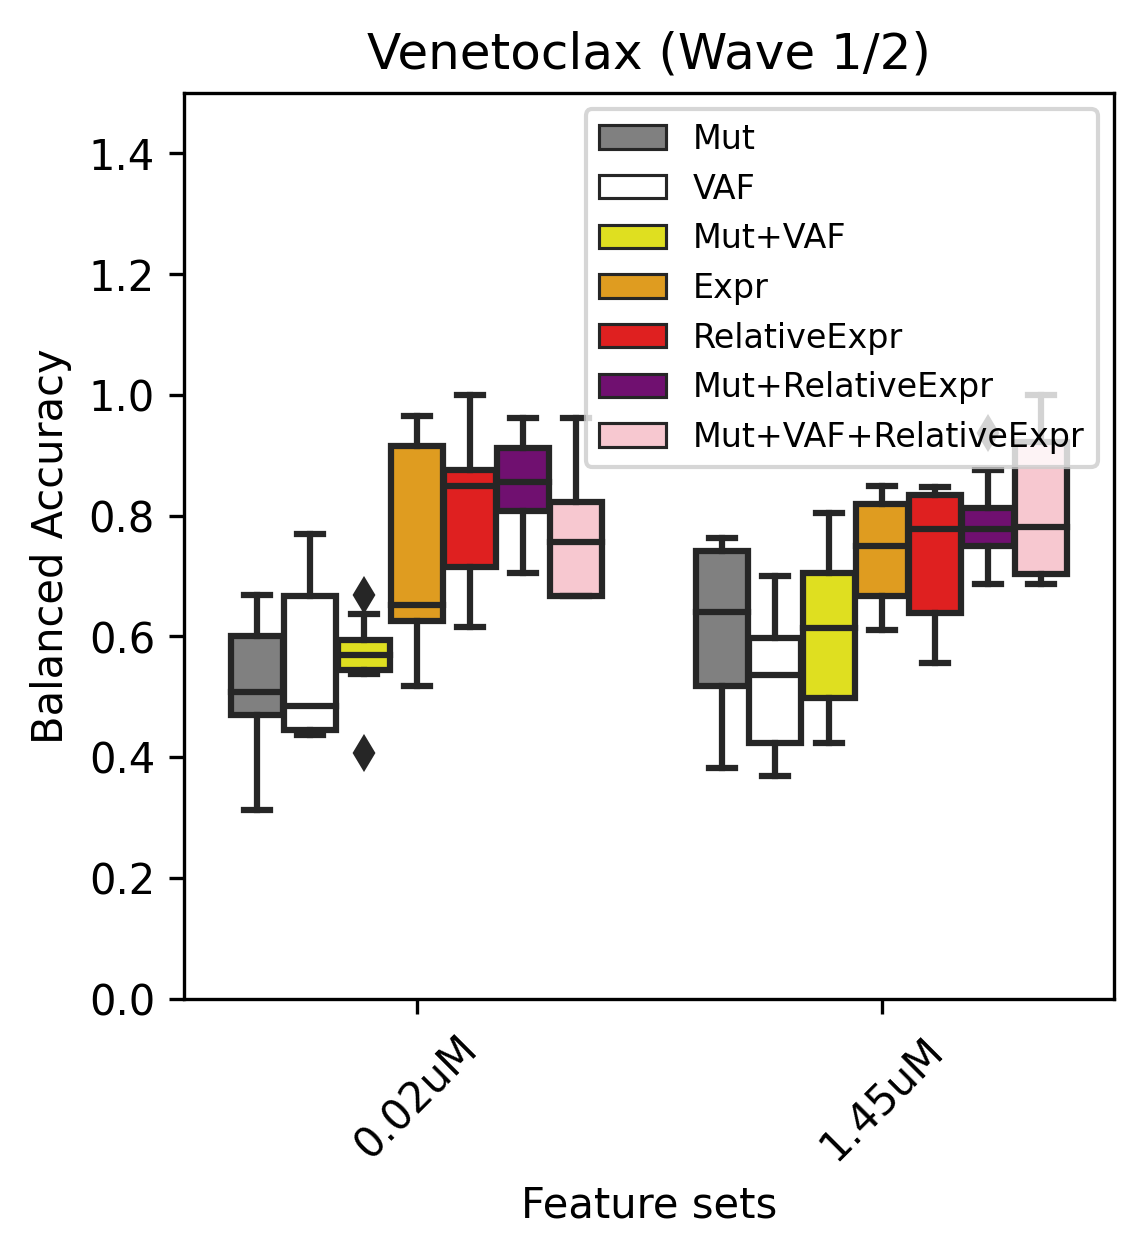

In [377]:
import seaborn as sns

result_df_cur_threshod = result_df.loc[result_df['Dataset'] =="W1/2(Validation)" ]

    #boxplot of result_df_cur_threshold grouped by feature_set
plt.figure(figsize = (4,4),dpi = 300)
sns.boxplot(x="Threshold", y="Balanced_ACC",
                hue="Feature_set", palette=["grey","white","yellow","orange" ,"red","purple","pink"],
                data=result_df_cur_threshod)
xticks_locs, xticks_labels = plt.xticks()
print(xticks_labels)
for i in range(0,len(xticks_labels)):
        xticks_labels[i] = str(round(float(xticks_labels[i].get_text()),2)) + "uM"

plt.xticks(xticks_locs, xticks_labels, rotation = 45)
plt.ylim(0,1.5)
plt.title(Drug.split("(")[0] +" (Wave 1/2)")
    #threshold_list_label = ["set1","set3","set4","set1&4"]
    #plt.xticks(range(0,len(threshold_list_label)), threshold_list_label, rotation = 90)
# set legend font size
plt.legend(fontsize = 8)
plt.ylabel("Balanced Accuracy")
plt.xlabel("Feature sets")


plt.show()




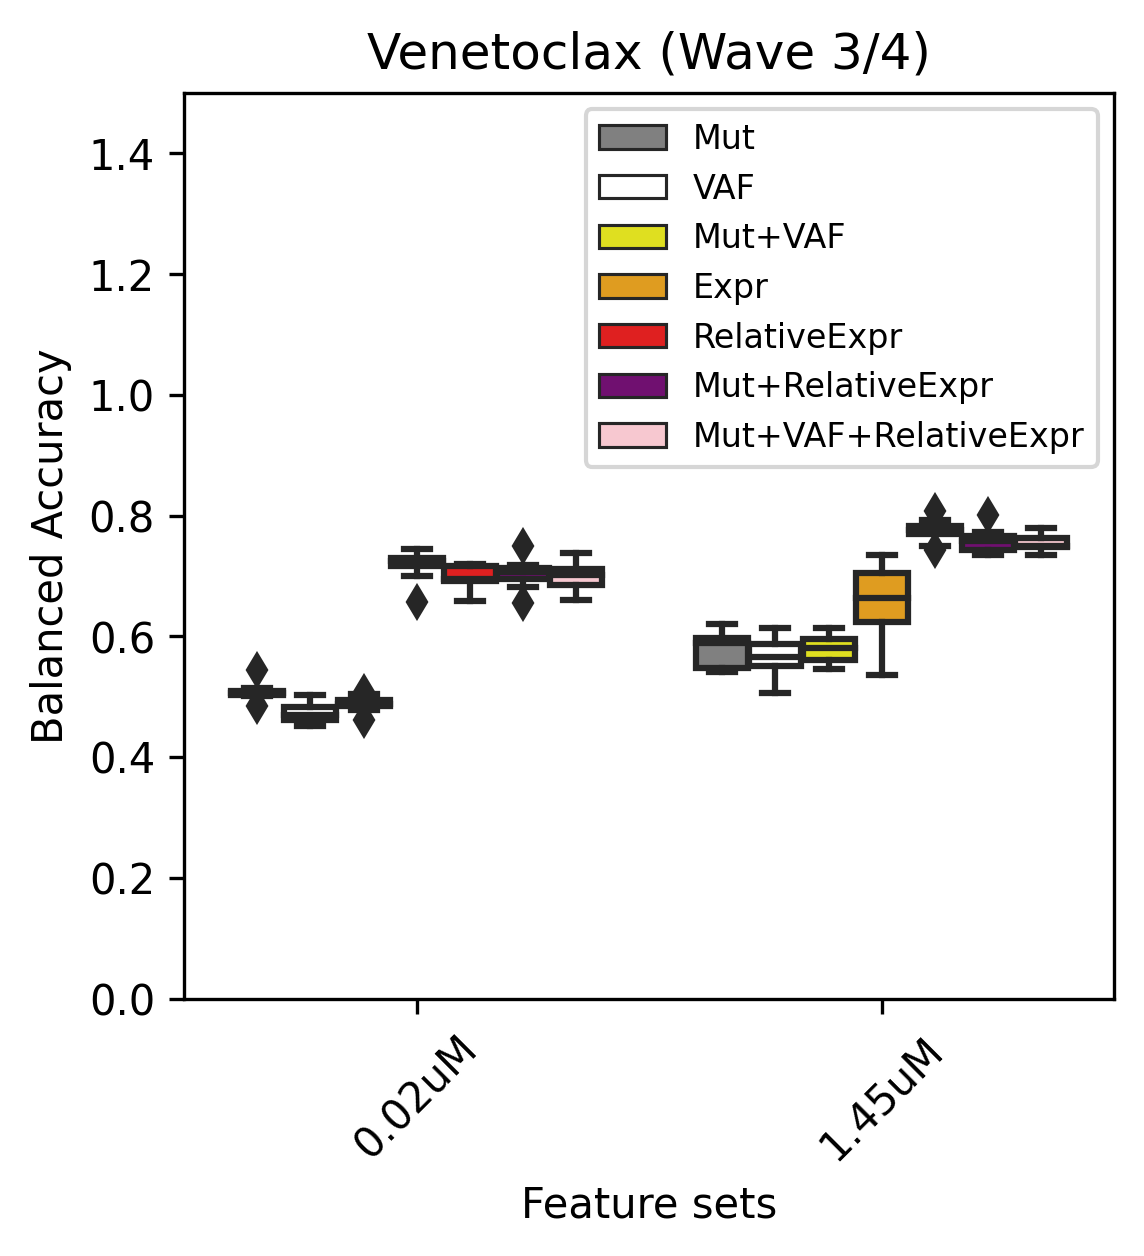

In [378]:

result_df_cur_threshod = result_df.loc[result_df['Dataset'] =="W3/4(Test)" ]

    #boxplot of result_df_cur_threshold grouped by feature_set
plt.figure(figsize = (4,4),dpi = 300)
sns.boxplot(x="Threshold", y="Balanced_ACC",
                hue="Feature_set", palette=["grey","white","yellow","orange" ,"red","purple","pink"],
                data=result_df_cur_threshod)
xticks_locs, xticks_labels = plt.xticks()
for i in range(0,len(xticks_labels)):
    xticks_labels[i] = str(round(float(xticks_labels[i].get_text()),2)) + "uM"

plt.xticks(xticks_locs, xticks_labels, rotation = 45)
plt.ylim(0,1.5)
plt.legend(fontsize = 8)
plt.title(Drug.split("(")[0]+" (Wave 3/4)" )
    #threshold_list_label = ["set1","set3","set4","set1&4"]

plt.ylabel("Balanced Accuracy")
plt.xlabel("Feature sets")
plt.show()

In [379]:
# get the median value for each group in the result_df_cur_threshod dataframe

result_df_cur_threshod.groupby(["Threshold","Feature_set"]).median()

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_67462/3277876921.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result_df_cur_threshod.groupby(["Threshold","Feature_set"]).median()


Balanced_ACC        F1
Threshold Feature_set                                 
0.019093  Expr                      0.724949  0.621352
          Mut                       0.505672  0.102597
          Mut+RelativeExpr          0.706835  0.592968
          Mut+VAF                   0.488347  0.118897
          Mut+VAF+RelativeExpr      0.701009  0.581840
          RelativeExpr              0.695260  0.569665
          VAF                       0.470373  0.042063
1.452619  Expr                      0.662740  0.778430
          Mut                       0.588293  0.575172
          Mut+RelativeExpr          0.757815  0.802048
          Mut+VAF                   0.581007  0.602046
          Mut+VAF+RelativeExpr      0.750450  0.791555
          RelativeExpr              0.775510  0.809408
          VAF                       0.566189  0.649433

[Text(0, 0, '0.0190925713799281'), Text(1, 0, '1.45261900330956')]


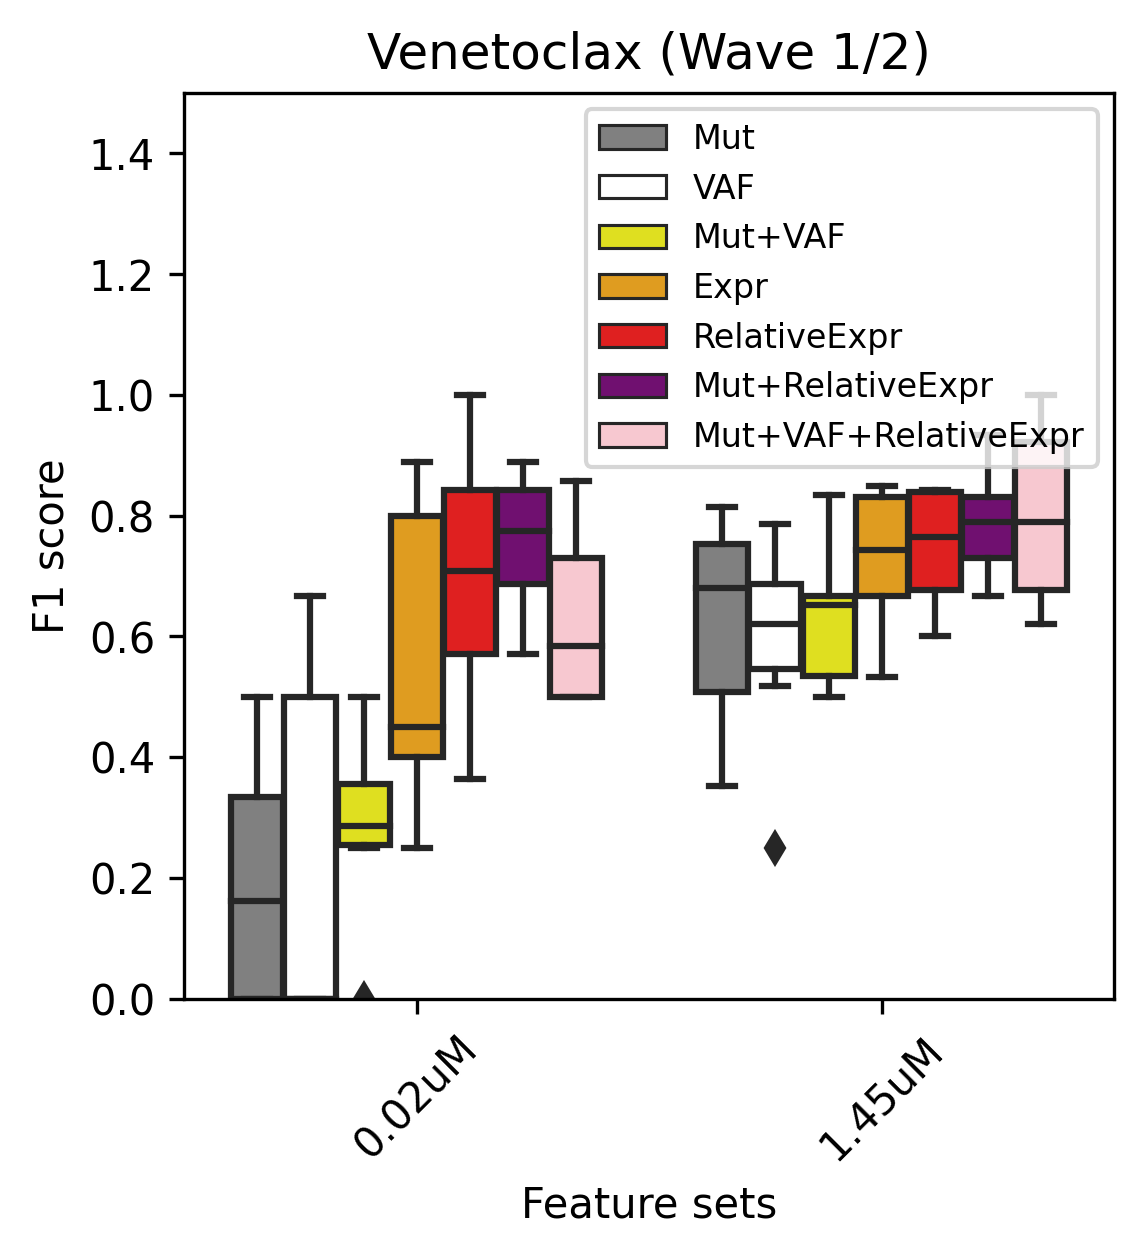

In [381]:
import seaborn as sns

result_df_cur_threshod = result_df.loc[result_df['Dataset'] =="W1/2(Validation)" ]

    #boxplot of result_df_cur_threshold grouped by feature_set
plt.figure(figsize = (4,4),dpi = 300)
sns.boxplot(x="Threshold", y="F1",
                hue="Feature_set", palette=["grey","white","yellow","orange" ,"red","purple","pink"],
                data=result_df_cur_threshod)
xticks_locs, xticks_labels = plt.xticks()
print(xticks_labels)
for i in range(0,len(xticks_labels)):
        xticks_labels[i] = str(round(float(xticks_labels[i].get_text()),2)) + "uM"

plt.xticks(xticks_locs, xticks_labels, rotation = 45)
plt.ylim(0,1.5)
plt.legend(fontsize = 8)
plt.title(Drug.split("(")[0] +" (Wave 1/2)")
    #threshold_list_label = ["set1","set3","set4","set1&4"]
    #plt.xticks(range(0,len(threshold_list_label)), threshold_list_label, rotation = 90)

plt.ylabel("F1 score")
plt.xlabel("Feature sets")
plt.show()




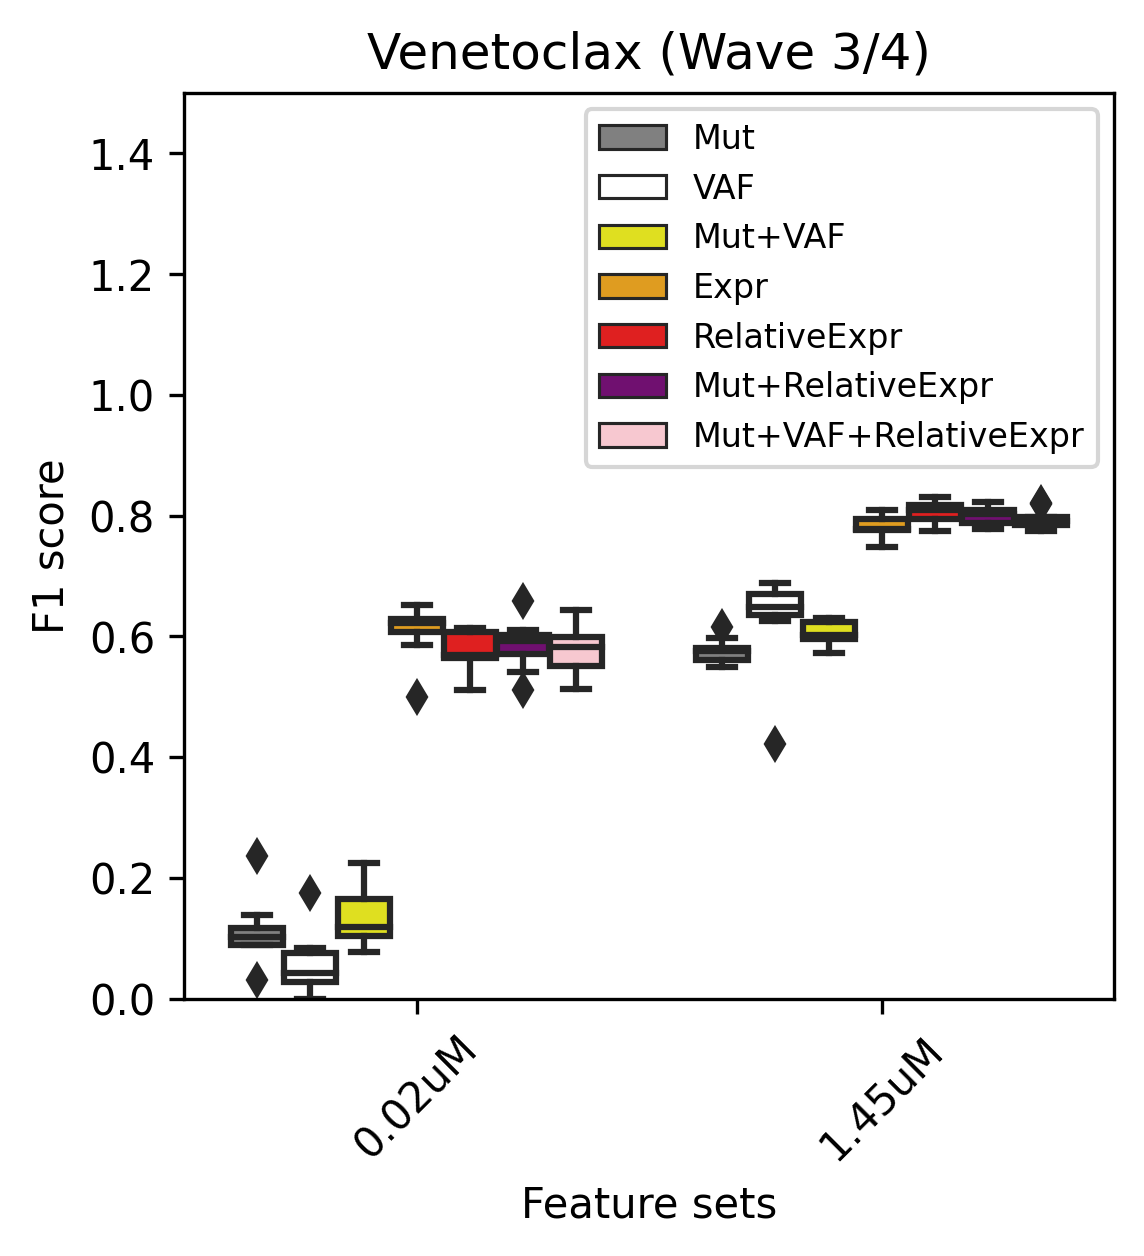

In [382]:

result_df_cur_threshod = result_df.loc[result_df['Dataset'] =="W3/4(Test)" ]

    #boxplot of result_df_cur_threshold grouped by feature_set
plt.figure(figsize = (4,4),dpi = 300)
sns.boxplot(x="Threshold", y="F1",
                hue="Feature_set", palette=["grey","white","yellow","orange" ,"red","purple","pink"],
                data=result_df_cur_threshod)
xticks_locs, xticks_labels = plt.xticks()
for i in range(0,len(xticks_labels)):
    xticks_labels[i] = str(round(float(xticks_labels[i].get_text()),2)) + "uM"

plt.xticks(xticks_locs, xticks_labels, rotation = 45)
plt.ylim(0,1.5)
plt.legend(fontsize = 8)
plt.title(Drug.split("(")[0]+" (Wave 3/4)" )
    #threshold_list_label = ["set1","set3","set4","set1&4"]
    
plt.ylabel("F1 score")
plt.xlabel("Feature sets")
plt.show()

In [383]:
result_df_cur_threshod.groupby(["Threshold","Feature_set"]).median()

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_67462/3367169410.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result_df_cur_threshod.groupby(["Threshold","Feature_set"]).median()


Balanced_ACC        F1
Threshold Feature_set                                 
0.019093  Expr                      0.724949  0.621352
          Mut                       0.505672  0.102597
          Mut+RelativeExpr          0.706835  0.592968
          Mut+VAF                   0.488347  0.118897
          Mut+VAF+RelativeExpr      0.701009  0.581840
          RelativeExpr              0.695260  0.569665
          VAF                       0.470373  0.042063
1.452619  Expr                      0.662740  0.778430
          Mut                       0.588293  0.575172
          Mut+RelativeExpr          0.757815  0.802048
          Mut+VAF                   0.581007  0.602046
          Mut+VAF+RelativeExpr      0.750450  0.791555
          RelativeExpr              0.775510  0.809408
          VAF                       0.566189  0.649433

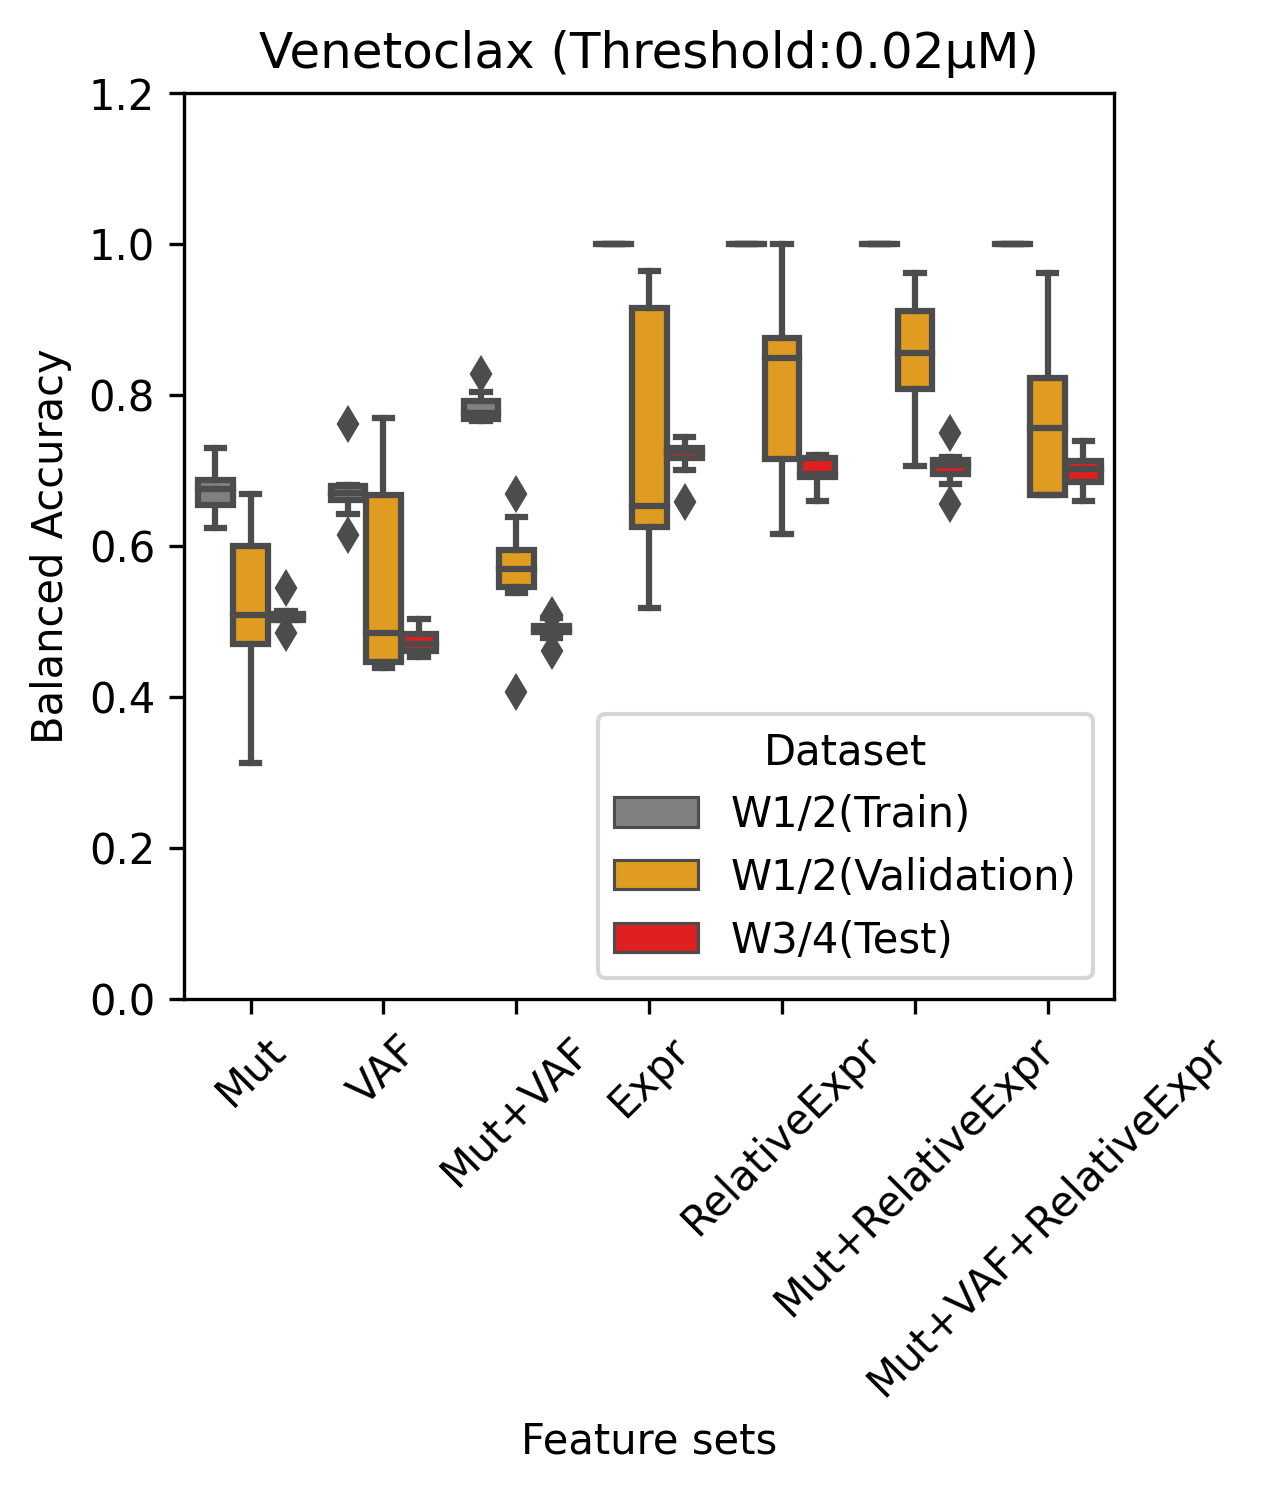

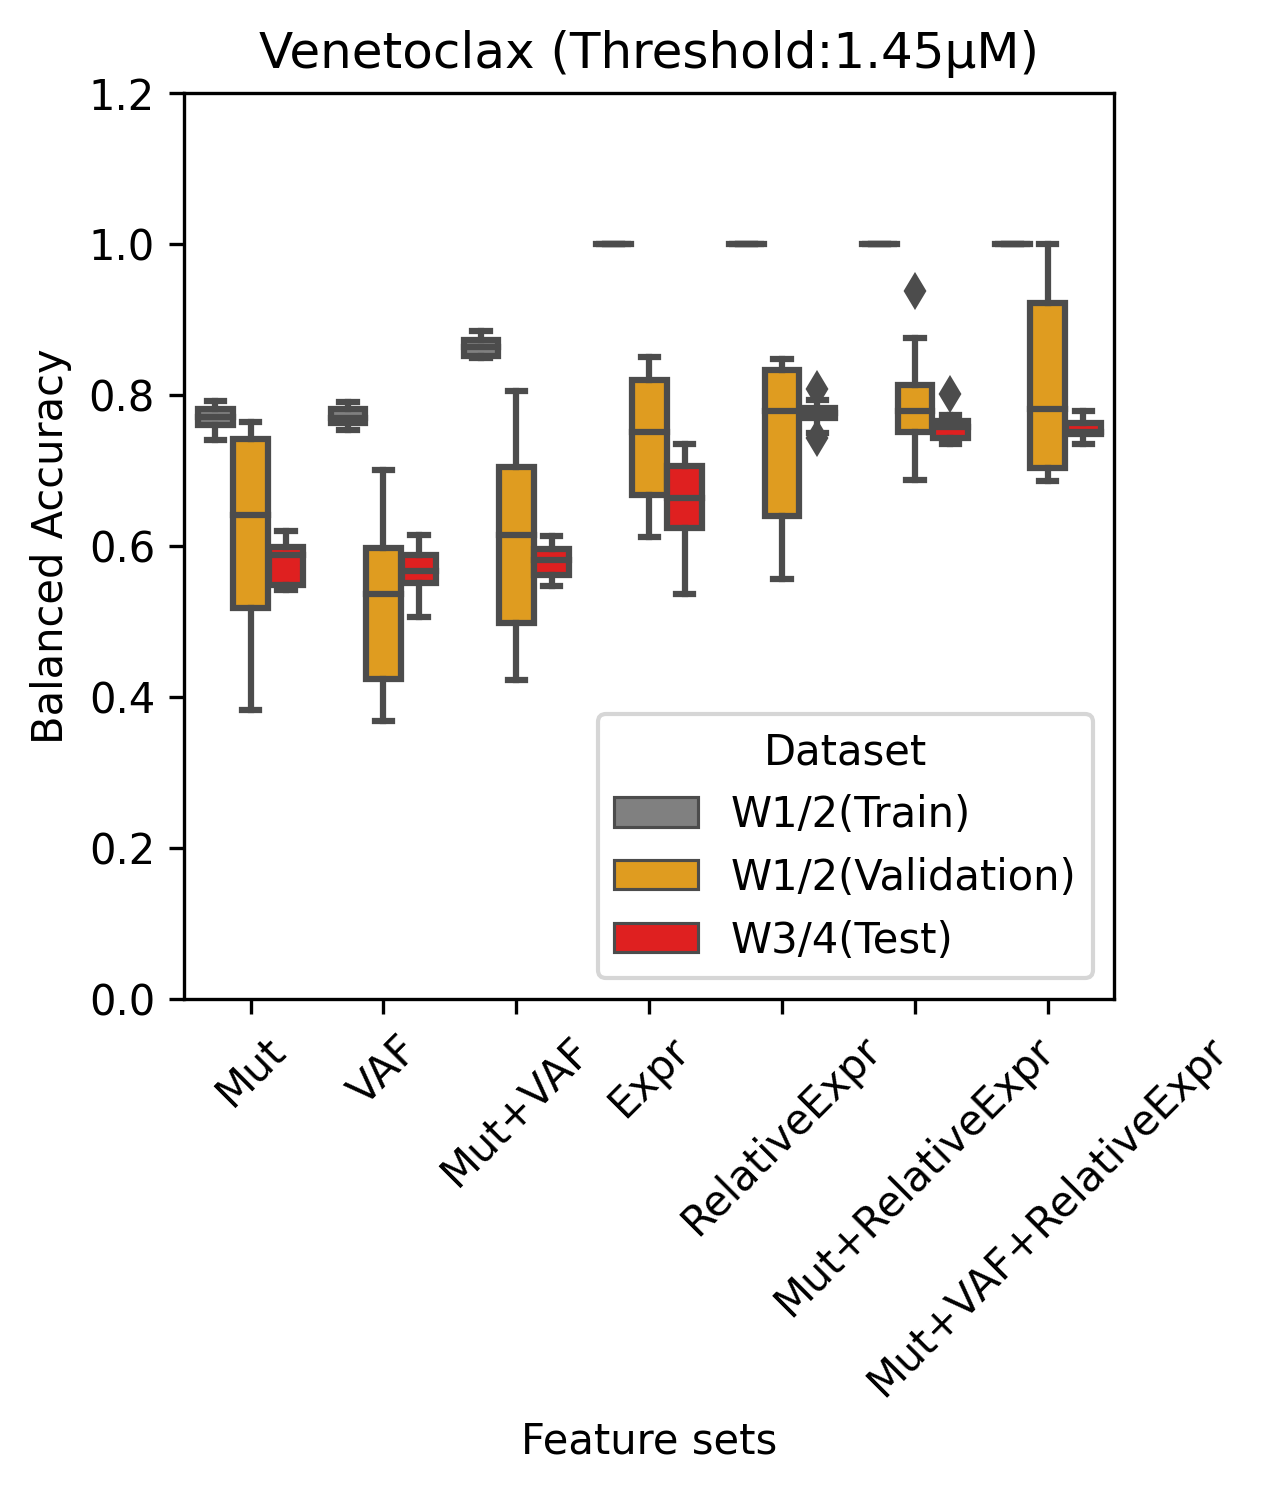

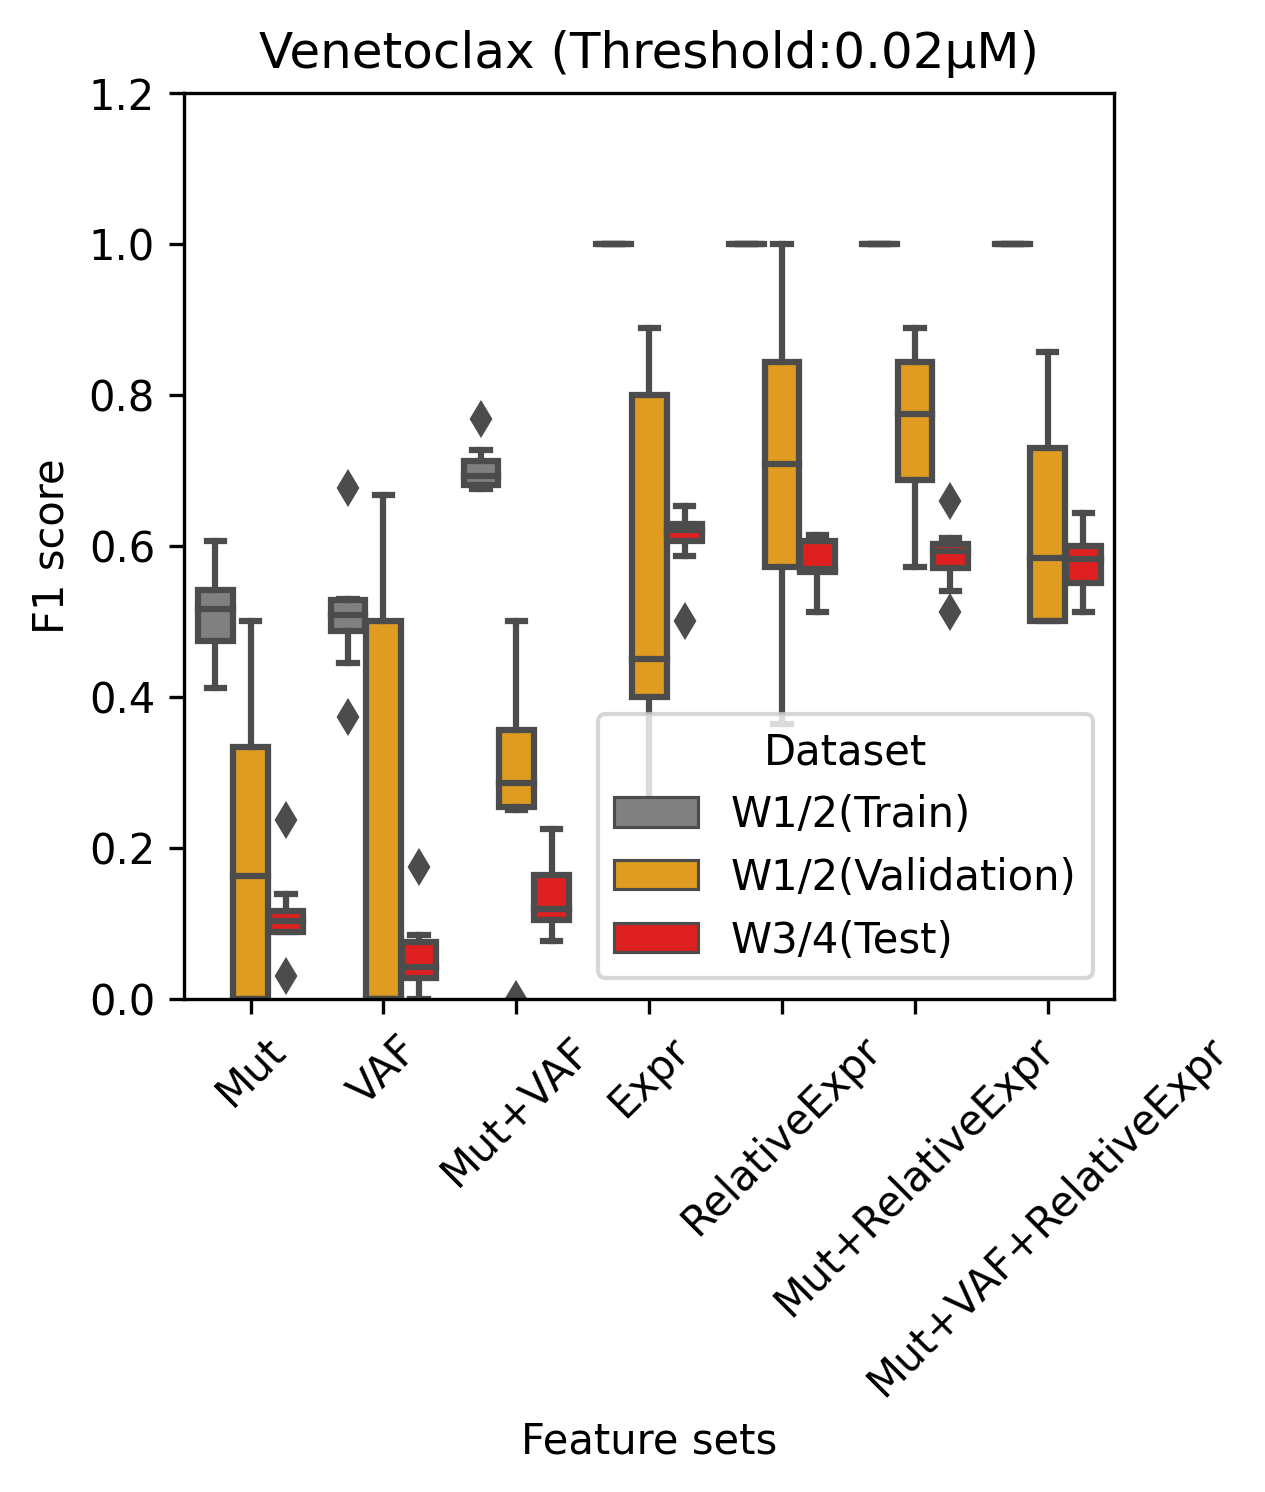

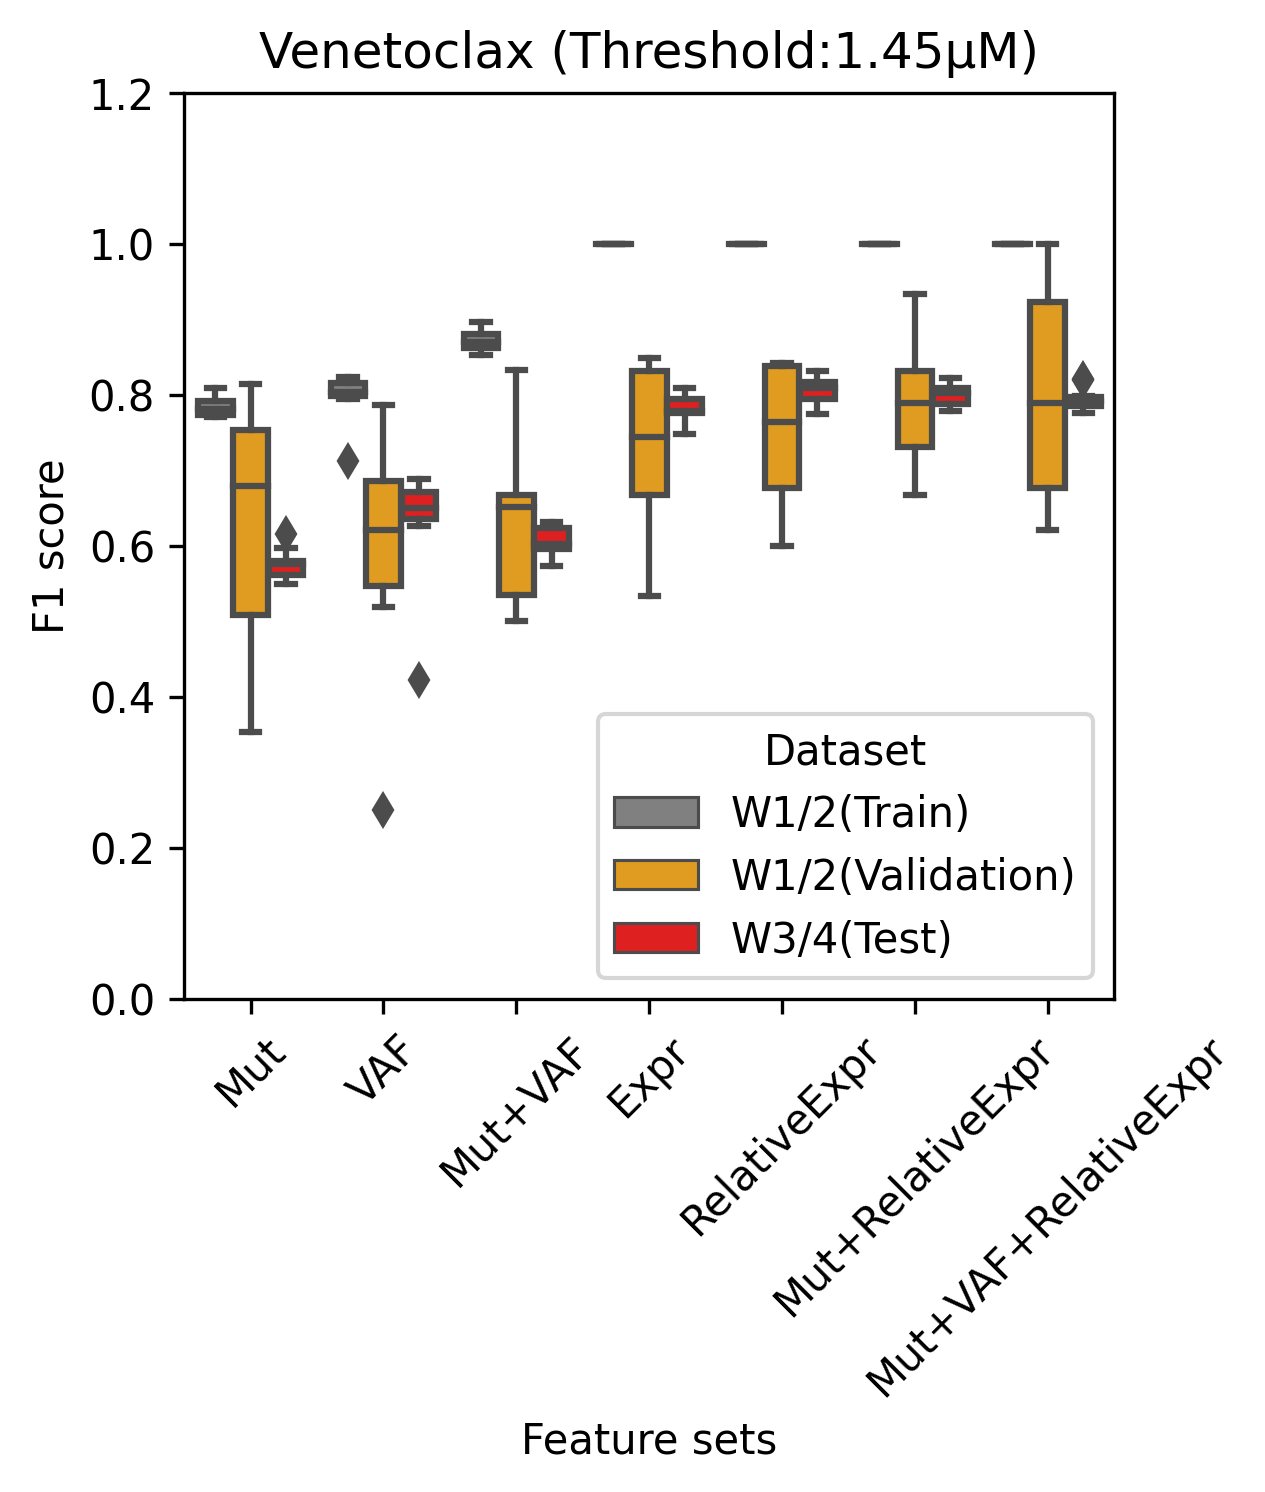

In [384]:
import seaborn as sns
for threshold in threshold_list:
    result_df_cur_threshod = result_df.loc[result_df['Threshold'] ==threshold ]

    #boxplot of result_df_cur_threshold grouped by feature_set
    plt.figure(figsize = (4,4),dpi = 300)
    sns.boxplot(x="Feature_set", y="Balanced_ACC",
                hue="Dataset", palette=["grey","orange" ,"red"],
                data=result_df_cur_threshod)
    
    plt.xticks(rotation = 45)
    plt.ylim(0,1.2)
    plt.title(Drug.split("(")[0] + " (Threshold:" + str(round(threshold,ndigits=2)) + "μM)")
    #threshold_list_label = ["set1","set3","set4","set1&4"]
    #plt.xticks(range(0,len(threshold_list_label)), threshold_list_label, rotation = 90)

    plt.ylabel("Balanced Accuracy")
    plt.xlabel("Feature sets")
    plt.show()


for threshold in threshold_list:
    result_df_cur_threshod = result_df.loc[result_df['Threshold'] ==threshold ]

    #boxplot of result_df_cur_threshold grouped by feature_set
    plt.figure(figsize = (4,4),dpi = 300)
    sns.boxplot(x="Feature_set", y="F1",
                hue="Dataset", palette=["grey","orange","red"],
                data=result_df_cur_threshod)
    plt.xticks(rotation = 45)
    plt.ylim(0,1.2)
    plt.title(Drug.split("(")[0] + " (Threshold:" + str(round(threshold,ndigits=2)) + "μM)")
    #threshold_list_label = ["set1","set3","set4","set1&4"]
    #plt.xticks(range(0,len(threshold_list_label)), threshold_list_label, rotation = 90)
    plt.ylabel("F1 score")
    plt.xlabel("Feature sets")
    plt.show()



In [41]:
result_df.to_csv("../Data/Balanced_ACC_feature_sets_venetoclax.csv")

In [98]:

r_data.loc[r_data['Feature_set'] == feature1]['Balanced_ACC'].values 
print(feature1)

Mut


In [99]:
r_data.loc[r_data['Feature_set'] == feature2]['Balanced_ACC'].values
print(feature2)

Mut


Mut Mut
Mut Expr
Mut RelativeExpr
Mut Mut+RelativeExpr
Expr Mut
Expr Expr
Expr RelativeExpr
Expr Mut+RelativeExpr
RelativeExpr Mut
RelativeExpr Expr
RelativeExpr RelativeExpr
RelativeExpr Mut+RelativeExpr
Mut+RelativeExpr Mut
Mut+RelativeExpr Expr
Mut+RelativeExpr RelativeExpr
Mut+RelativeExpr Mut+RelativeExpr


([<matplotlib.axis.YTick at 0x14ccb49d0>,
 [Text(0, 0.5, 'Mut'),
  Text(0, 1.5, 'Expr'),
  Text(0, 2.5, 'RelativeExpr'),
  Text(0, 3.5, 'Mut+RelativeExpr')])

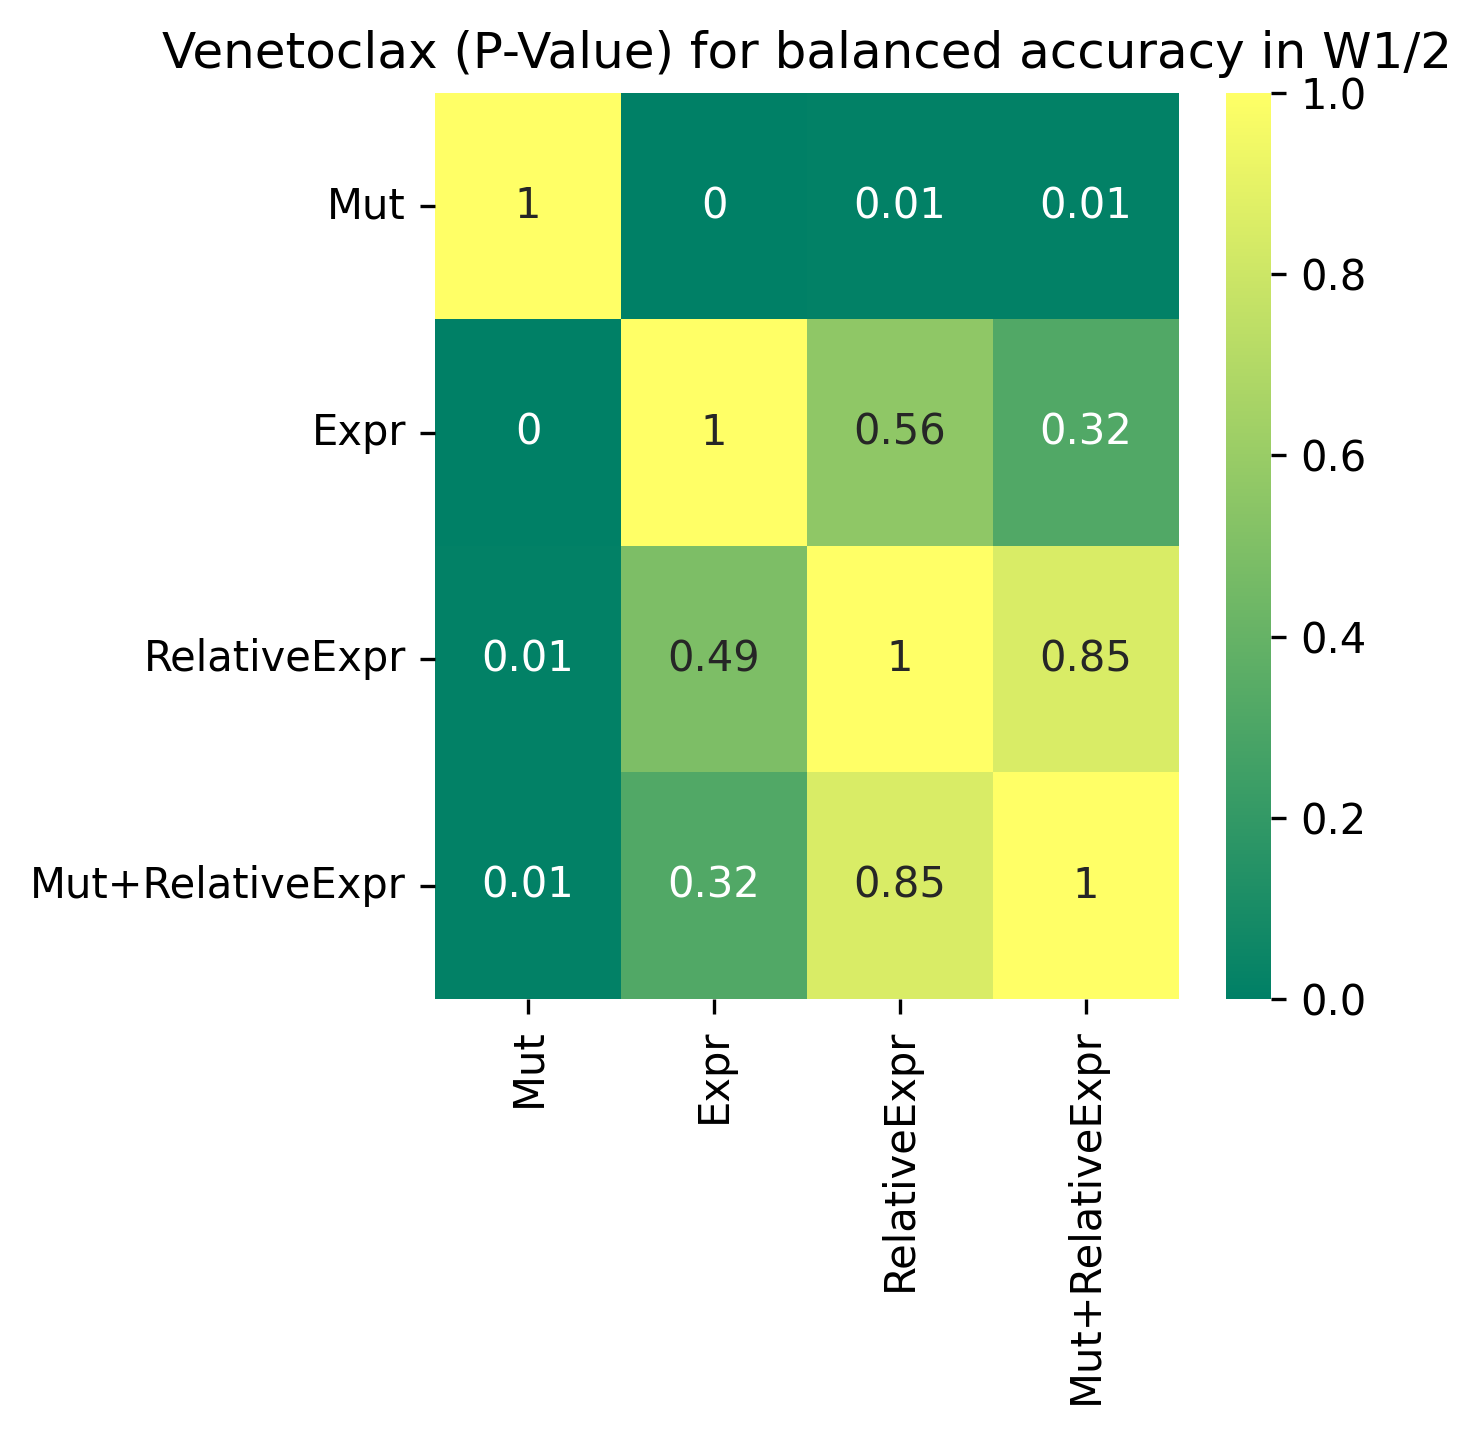

In [100]:

r_data = result_df.loc[result_df['Dataset'] == 'W1/2(Validation)']
r_data = r_data.loc[r_data['Threshold'] == 1.45261900330956	]
# ranksum test
from scipy.stats import ranksums, wilcoxon
featureset = [ 'Mut', 'Expr', 'RelativeExpr', 'Mut+RelativeExpr']

result_p = pd.DataFrame()
row_list = []
for feature1 in featureset:
    p_list_cur = []
    for feature2 in featureset:
        print(feature1, feature2)
        if feature1 != feature2:
            d = r_data.loc[r_data['Feature_set'] == feature1]['Balanced_ACC'].values  - r_data.loc[r_data['Feature_set'] == feature2]['Balanced_ACC'].values
            p = wilcoxon(d)[1]
        else:
            p = 1
        #p = ranksums(r_data.loc[r_data['Feature_set'] == feature1]['Balanced_ACC'].values, 
        #             r_data.loc[r_data['Feature_set'] == feature2]['Balanced_ACC'].values)[1]
        p_list_cur.append(round(p,2))

    result_p[feature1] = p_list_cur


# heatmap plot for p value
plt.figure(figsize = (4,4),dpi = 300)
sns.heatmap(result_p, annot=True, cmap="summer")
plt.title(Drug + " (P-Value) for balanced accuracy in W1/2")
#plt.xticks([0.5,1.5,2.5,3.5,4,5,5.5], featureset, rotation = 90)
plt.yticks([0.5,1.5,2.5,3.5], featureset, rotation = 0)
# set fontsize for the legend

In [92]:
r_data

,Threshold,Feature_set,Balanced_ACC,F1,Dataset
200,1.452619,Mut,0.587678,0.616162,W3/4(Test)
201,1.452619,Mut,0.626291,0.620321,W3/4(Test)
202,1.452619,Mut,0.575566,0.590674,W3/4(Test)
203,1.452619,Mut,0.589769,0.576087,W3/4(Test)
204,1.452619,Mut,0.550111,0.594059,W3/4(Test)
205,1.452619,Mut,0.550295,0.557895,W3/4(Test)
206,1.452619,Mut,0.549250,0.578680,W3/4(Test)
207,1.452619,Mut,0.622664,0.592179,W3/4(Test)
208,1.452619,Mut,0.655558,0.609195,W3/4(Test)
209,1.452619,Mut,0.576611,0.569892,W3/4(Test)


([<matplotlib.axis.YTick at 0x14b528940>,
 [Text(0, 0.5, 'Mut'),
  Text(0, 1.5, 'Expr'),
  Text(0, 2.5, 'RelativeExpr'),
  Text(0, 3.5, 'Mut+RelativeExpr')])

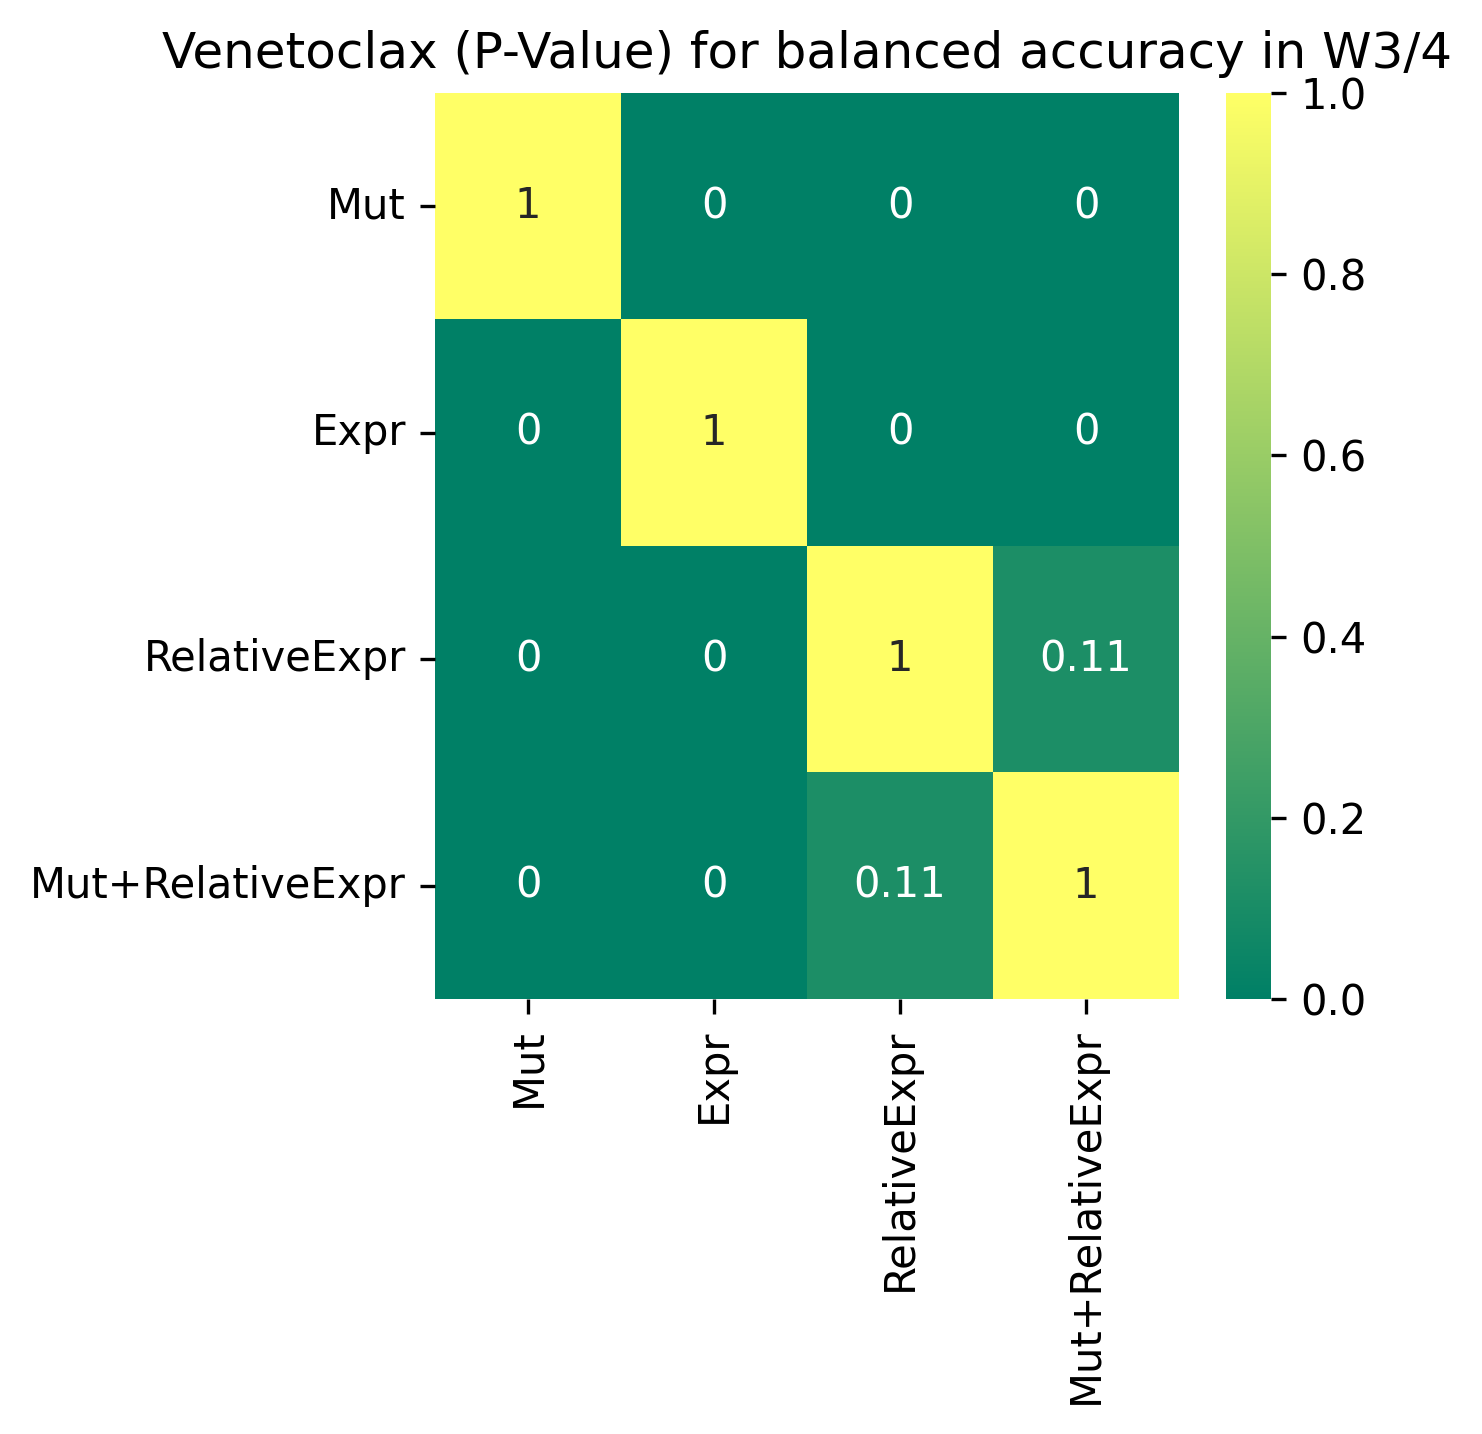

In [101]:
r_data = result_df.loc[result_df['Dataset'] == 'W3/4(Test)']
r_data = r_data.loc[r_data['Threshold'] == 1.45261900330956	]

# ranksum test
from scipy.stats import ranksums,wilcoxon
featureset = [ 'Mut', 'Expr', 'RelativeExpr', 'Mut+RelativeExpr']

result_p = pd.DataFrame()
row_list = []
for feature1 in featureset:
    p_list_cur = []
    for feature2 in featureset:
        if feature1 != feature2:
            d = r_data.loc[r_data['Feature_set'] == feature1]['Balanced_ACC'].values - r_data.loc[r_data['Feature_set'] == feature2]['Balanced_ACC'].values
            p = wilcoxon(d)[1]
        else:
            p = 1

        #print(feature1, feature2)
        #d = r_data.loc[r_data['Feature_set'] == feature1]['Balanced_ACC'].values - r_data.loc[r_data['Feature_set'] == feature2]['Balanced_ACC'].values
        #print(d)
        #p = wilcoxon(d)[1]
        p_list_cur.append(round(p,2))

    result_p[feature1] = p_list_cur


# heatmap plot for p value
plt.figure(figsize = (4,4),dpi = 300)
sns.heatmap(result_p, annot=True, cmap="summer")
plt.title(Drug + " (P-Value) for balanced accuracy in W3/4")
#plt.xticks([0.5,1.5,2.5,3.5,4,5,5.5], featureset, rotation = 90)
plt.yticks([0.5,1.5,2.5,3.5], featureset, rotation = 0)
# set fontsize for the legend

([<matplotlib.axis.YTick at 0x1520bd570>,
 [Text(0, 0.5, 'Mut'),
  Text(0, 1.5, 'Expr'),
  Text(0, 2.5, 'RelativeExpr'),
  Text(0, 3.5, 'Mut+RelativeExpr')])

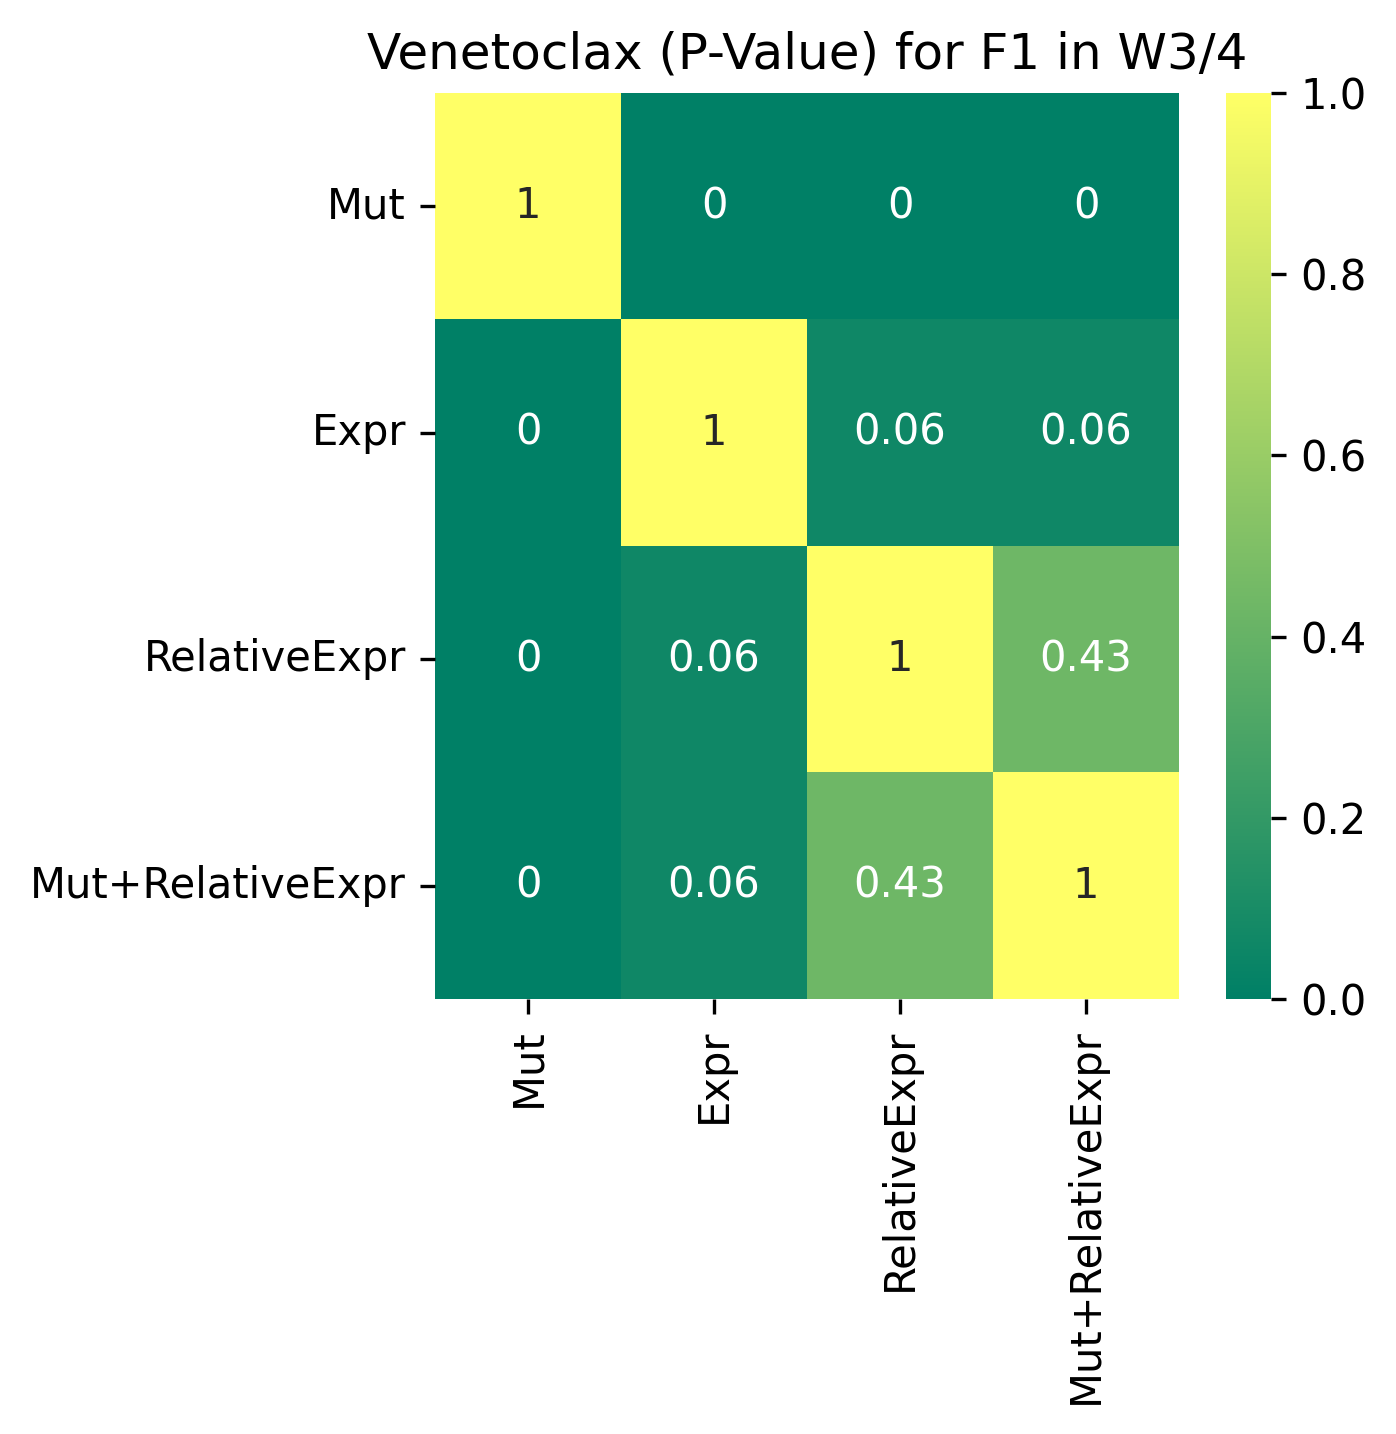

In [102]:
r_data = result_df.loc[result_df['Dataset'] == 'W3/4(Test)']
r_data = r_data.loc[r_data['Threshold'] == 1.45261900330956	]

# ranksum test
from scipy.stats import ranksums,wilcoxon
featureset = [ 'Mut', 'Expr', 'RelativeExpr', 'Mut+RelativeExpr']

result_p = pd.DataFrame()
row_list = []
for feature1 in featureset:
    p_list_cur = []
    for feature2 in featureset:
        if feature1 != feature2:
            d = r_data.loc[r_data['Feature_set'] == feature1]['F1'].values - r_data.loc[r_data['Feature_set'] == feature2]['F1'].values
            p = wilcoxon(d)[1]
        else:
            p = 1

        #print(feature1, feature2)
        #d = r_data.loc[r_data['Feature_set'] == feature1]['Balanced_ACC'].values - r_data.loc[r_data['Feature_set'] == feature2]['Balanced_ACC'].values
        #print(d)
        #p = wilcoxon(d)[1]
        p_list_cur.append(round(p,2))

    result_p[feature1] = p_list_cur


# heatmap plot for p value
plt.figure(figsize = (4,4),dpi = 300)
sns.heatmap(result_p, annot=True, cmap="summer")
plt.title(Drug + " (P-Value) for F1 in W3/4")
#plt.xticks([0.5,1.5,2.5,3.5,4,5,5.5], featureset, rotation = 90)
plt.yticks([0.5,1.5,2.5,3.5], featureset, rotation = 0)
# set fontsize for the legend

In [114]:
len(cur_df.loc[cur_df['Dataset'] == 'W1/2(Validation)']['Balanced_ACC'].values)

10

In [115]:
r_data = result_df.loc[result_df['Threshold'] == 1.45261900330956]

# compare groups between w1/2 and w3/4 
# ranksum test
from scipy.stats import ranksums, wilcoxon
featureset = [ 'Mut', 'Expr', 'RelativeExpr', 'Mut+RelativeExpr']

result_p = pd.DataFrame()
row_list = []

p_list_cur = []
for feature1 in featureset:
    print(feature1)
    cur_df = r_data.loc[r_data['Feature_set'] == feature1]
    d = cur_df.loc[cur_df['Dataset'] == 'W3/4(Test)']['Balanced_ACC'].values - cur_df.loc[cur_df['Dataset'] == 'W1/2(Validation)']['Balanced_ACC'].values
    p = ranksums(cur_df.loc[cur_df['Dataset'] == 'W3/4(Test)']['Balanced_ACC'].values, 
                 cur_df.loc[cur_df['Dataset'] == 'W1/2(Validation)']['Balanced_ACC'].values)[1]
    print("ranksums")
    print(p)
    print("wilcoxon")
    p = wilcoxon(d)[1]
    print(p)
    p_list_cur.append(p)

print("P values between W1/2 and W3/4")
print(p_list_cur)

Mut
ranksums
0.034293721036492766
wilcoxon
0.064453125
Expr
ranksums
0.034293721036492766
wilcoxon
0.10546875
RelativeExpr
ranksums
0.6501474440948545
wilcoxon
0.6953125
Mut+RelativeExpr
ranksums
0.5967012167293563
wilcoxon
0.76953125
P values between W1/2 and W3/4
[0.064453125, 0.10546875, 0.6953125, 0.76953125]


In [110]:
r_data = result_df.loc[result_df['Threshold'] == 1.45261900330956]

# compare groups between w1/2 and w3/4 
# ranksum test
from scipy.stats import ranksums, wilcoxon
featureset = [ 'Mut', 'Expr', 'RelativeExpr', 'Mut+RelativeExpr']

result_p = pd.DataFrame()
row_list = []

p_list_cur = []
for feature1 in featureset:
    print(feature1)
    
    cur_df = r_data.loc[r_data['Feature_set'] == feature1]
    d = cur_df.loc[cur_df['Dataset'] == 'W3/4(Test)']['F1'].values - cur_df.loc[cur_df['Dataset'] == 'W1/2(Validation)']['F1'].values
    p = wilcoxon(d)[1]
    print(p)
    p_list_cur.append(p)

print("P values between W1/2 and W3/4")
print(p_list_cur)

Mut
0.037109375
Expr
0.193359375
RelativeExpr
0.4921875
Mut+RelativeExpr
0.232421875
P values between W1/2 and W3/4
[0.037109375, 0.193359375, 0.4921875, 0.232421875]


In [40]:
result_with_threshod.keys()

dict_keys([0.0190925713799281, 1.45261900330956])

(200, 7)


Text(0, 0.5, 'Feature importance (Mut+VAF+RelativeExpr)')

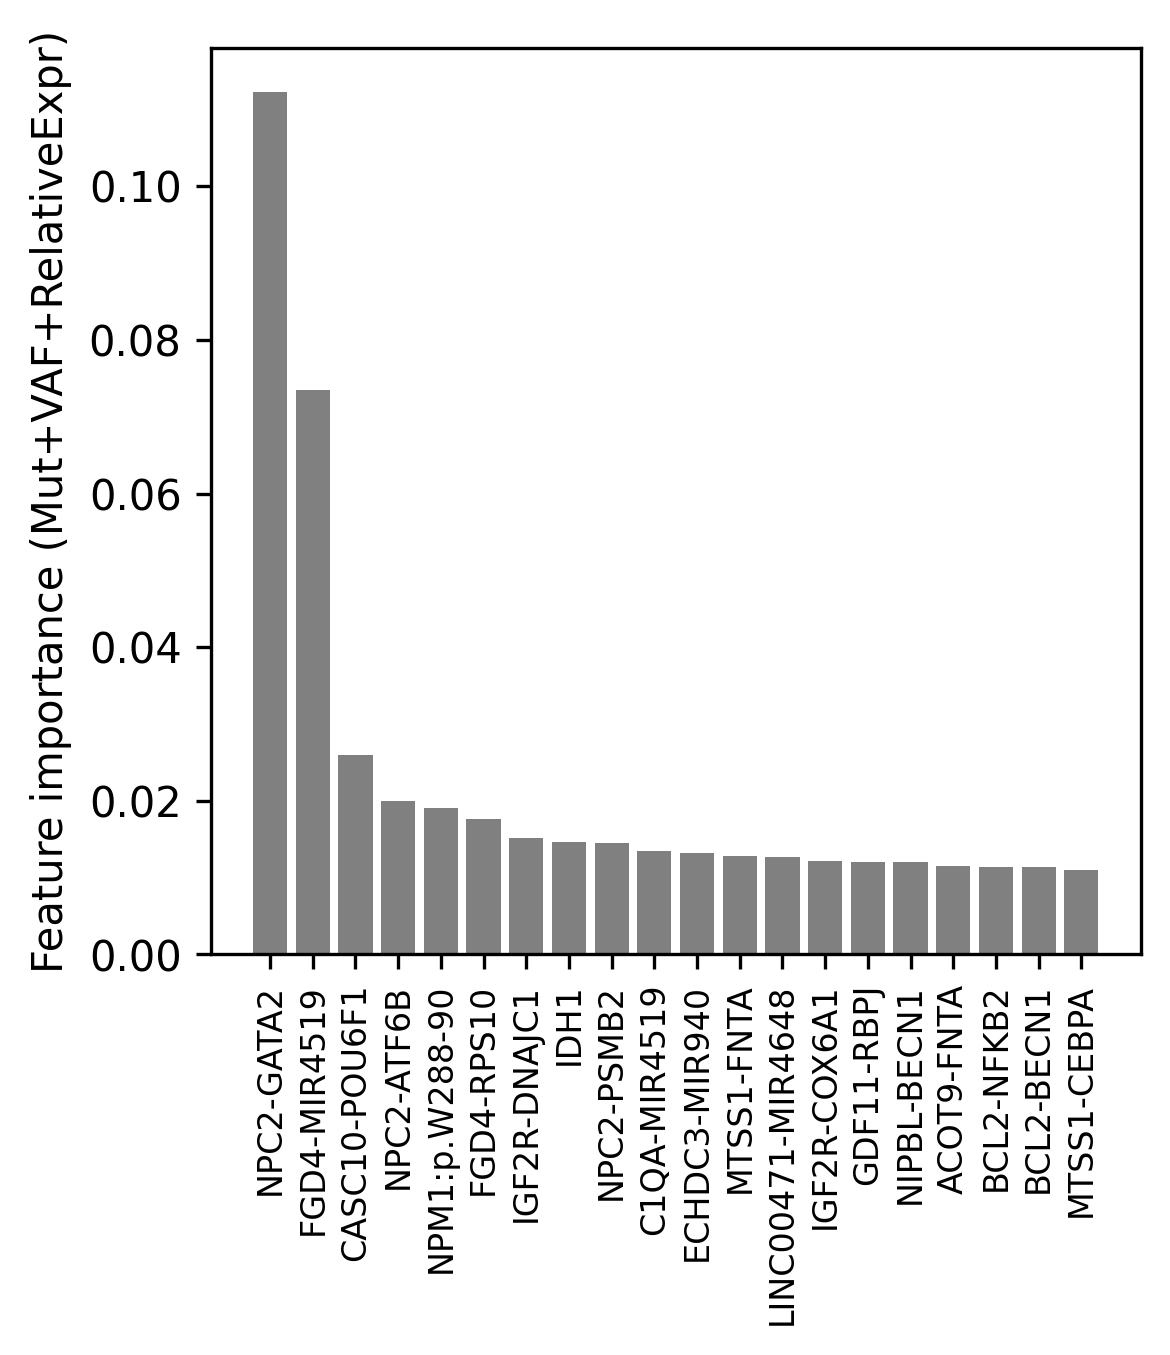

In [386]:

feature_IMP =pd.DataFrame()
Threshold = 1.45261900330956
featureset_cur = "RelativeExpr"
#featureset_cur = "Expr"
featureset_cur = "Mut+VAF+RelativeExpr"
#featureset_cur = "Mut"

for random_state in result_with_threshod[Threshold][featureset_cur]:
    if result_with_threshod[Threshold][featureset_cur][random_state]['balanced_acc'] > 0.7:
        features = result_with_threshod[Threshold][featureset_cur][random_state]['features']['Feature'].values
        IMP = result_with_threshod[Threshold][featureset_cur][random_state]['features']['IMP'].values
        cur_df = pd.DataFrame({"IMP" + str(random_state): IMP})
        cur_df.index = features
        feature_IMP = pd.concat([feature_IMP,cur_df ],axis =1)
print(feature_IMP.shape)
IMP_sum = feature_IMP.transpose().sum()/feature_IMP.transpose().shape[0]
x_feature = pd.DataFrame({"Feature":IMP_sum.index, "IMP":IMP_sum.values})
x_feature_sorted = x_feature.sort_values(by = ["IMP"], ascending = False).head(20)

plt.figure(figsize = (4,4),dpi = 300)
plt.bar(np.arange(0,x_feature_sorted.shape[0], 1), x_feature_sorted['IMP'], width=0.8,  color = 'grey',
        bottom=None,  align='center')
#plt.ylabel("correlation coeffient")

xticks_new = []
for i in x_feature_sorted['Feature']:
    
    if i.startswith("ENSG") and i in dic_gene_map:
        xticks_new.append(dic_gene_map[i])
    else: 
        xticks_new.append(i)


plt.xticks(np.arange(0,x_feature_sorted.shape[0], 1),xticks_new , rotation = 90, fontsize =8)
plt.ylabel("Feature importance (" + featureset_cur + ")")




In [387]:
# Plot top important features 
feature_IMP =pd.DataFrame()
Threshold = 1.0846102336359151
featureset_cur = "RelativeExpr"
featureset_cur = "Expr"
for random_state in result_with_threshod[Threshold][featureset_cur]:
    if result_with_threshod[Threshold][featureset_cur][random_state]['balanced_acc'] > 0.7:
        features = result_with_threshod[Threshold][featureset_cur][random_state]['features']['Feature'].values
        IMP = result_with_threshod[Threshold][featureset_cur][random_state]['features']['IMP'].values
        cur_df = pd.DataFrame({"IMP" + str(random_state): IMP})
        cur_df.index = features
        feature_IMP = pd.concat([feature_IMP,cur_df ],axis =1)
print(feature_IMP.shape)
IMP_sum = feature_IMP.transpose().sum()/feature_IMP.transpose().shape[0]
x_feature = pd.DataFrame({"Feature":IMP_sum.index, "IMP":IMP_sum.values})
x_feature_sorted = x_feature.sort_values(by = ["IMP"], ascending = False).head(20)

plt.figure(figsize = (4,3),dpi = 300)
plt.title("Feature_importance: " + Drug.split("(")[0])
plt.bar(np.arange(0,x_feature_sorted.shape[0], 1), x_feature_sorted['IMP'], width=0.8,  color = 'grey',
        bottom=None,  align='center')
#plt.ylabel("correlation coeffient")
xticks_new = []
for i in x_feature_sorted['Feature']:
    
    if i.startswith("ENSG") and i in dic_gene_map:
        xticks_new.append(dic_gene_map[i])
    else: 
        xticks_new.append(i)


plt.xticks(np.arange(0,x_feature_sorted.shape[0], 1),xticks_new , rotation = 90, fontsize =8)


KeyError: 1.0846102336359151